# Notebook 1 of 2 - Data Preprocessing, Feature Engineering and Data Augmentation

This notebook contains the following components of our Machine Learning pipeline:
1. Data preprocessing
2. Feature extraction
3. Feature selection
4. Data augmentation

## Import Packages

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random
import re
import warnings
import math

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

# datetime for manipulating date and time
import datetime

# scipy
import scipy.stats as stats
from scipy.optimize import curve_fit

random.seed(2)

## EDA Visualization Functions

In [16]:
def plot_frequencies(data, features, num_rows, num_cols, figsize, title):
    """
    Plots frequencies of categorical features in a dataset.

    Params:
        data: dataframe containing features to plot
        features: list of features to plot
        num_rows: number of rows in grid of plots
        num_cols: number of columns in grid of plots
        figsize: size of each plot
        title: title of each plot
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = sns.countplot(data=data, x=feature, ax=axes[i])
        ax.set_title(title + feature)

        # Set y-axis to count instead of percentage
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        # Rotate x-axis labels by 45 degrees
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Remove extra subplots    
    if len(features) < num_rows * num_cols:
        for j in range(len(features), num_rows * num_cols):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# For every unique number, plot the activity values aggregated by hour after first timestamp to check no 'tails' of 0 activity
def plot_activity_by_hour(df, time_level='hour_after_first'):
    """
    Plots activity by time_level after first timestamp for each unique number in the dataset.

    Params:
        df: dataframe containing columns 'number', 'timestamp', and 'activity'
        time_level: time level to plot activity by. Must be one of ['minute_after_first', 'hour_after_first', 'day_after_first']
    """

    # Raise error if time_level is not in ['minute_after_first', 'hour_after_first', 'day_after_first']
    if time_level not in ['minute_after_first', 'hour_after_first', 'day_after_first']:
        raise ValueError("time_level must be one of ['minute_after_first', 'hour_after_first', 'day_after_first']")

    # Plot activity by time_level after first timestamp for each unique number
    else:
        for number in df['number'].unique():
            plt.figure(figsize=(15, 2))
            df[df['number'] == number].groupby(time_level)['activity'].sum().plot()
            plt.title("Activity by hour after first timestamp for " + number)
            plt.xlabel("Hour after first timestamp")
            plt.ylabel("Activity")
            plt.show()

def time_activity_plot_single(data, time_col, window_size=1, ax=None):
    """
    Plot activity by single time_col (e.g., hour, day, day_of_week, week_of_year, month)
    
    Params:
        data: dataframe containing columns 'activity' and time_col
        time_col: time column to plot activity by. Must be one of ['hour', 'day', 'day_of_week', 'week_of_year', 'month']
        window_size: window size for smoothing
        ax: axis to plot on
    
    Returns:
        None
    """
    madrs2_groups = data['madrs2_grouped'].unique()
    for group in madrs2_groups:
        activity_mean = data[data['madrs2_grouped'] == group].groupby(time_col)['activity'].mean()
        activity_smoothed = activity_mean.rolling(window_size, min_periods=1, center=True).mean()
        activity_smoothed.plot(label=group, ax=ax)
    ax.legend()
    ax.set_xlabel(time_col)
    ax.set_ylabel('Activity')
    ax.set_title(f'Distribution of Activity by {time_col.capitalize()}')

def time_activity_plot_combo(data, time_col_1, time_col_2, window_size=1, ax=None):
    """
    Plot activity by combination of two time_cols (e.g., hour-minute, day-hour, day_of_week-hour, day_of_week-minute_of_day)
    
    Params:
        data: dataframe containing columns 'activity' and time_col_1 and time_col_2
        time_col_1: first time column to plot activity by. Must be one of ['hour', 'day', 'day_of_week', 'week_of_year', 'month']
        time_col_2: second time column to plot activity by. Must be one of ['minute', 'hour', 'day', 'day_of_week', 'week_of_year', 'month']
        window_size: window size for smoothing
        ax: axis to plot on
    """
    madrs2_groups = data['madrs2_grouped'].unique()
    data['time'] = data[time_col_1].astype(str).str.zfill(2) + '-' + data[time_col_2].astype(str) 
    for group in madrs2_groups:
        activity_mean = data[data['madrs2_grouped'] == group].groupby('time')['activity'].mean()
        activity_smoothed = activity_mean.rolling(window_size, min_periods=1, center=True).mean()
        activity_smoothed.plot(label=group, ax=ax)
    ax.legend()
    ax.set_xlabel(f'Time ({time_col_1.capitalize()}-{time_col_2.capitalize()})')
    ax.set_ylabel('Activity')
    ax.set_title(f'Distribution of Activity by {time_col_1.capitalize()}-{time_col_2.capitalize()}\n Smoothed over {window_size} {time_col_2.capitalize()}')

def plot_activity_heatmap(df, x_axis, y_axis, num_rows=1, num_cols=3, figsize=(20,3), countplot=True):
    """
    Creates a 1x3 grid of heatmaps of mean activity based on two time scales for each madrs2_group.

    Params:
        df: dataframe containing columns 'activity', 'madrs2_grouped', x_axis, and y_axis
        x_axis: first time column to plot activity by. Must be one of ['hour', 'day', 'day_of_week', 'week_of_year', 'month']
        y_axis: second time column to plot activity by. Must be one of ['minute', 'hour', 'day', 'day_of_week', 'week_of_year', 'month']
        num_rows: number of rows in grid of heatmaps
        num_cols: number of columns in grid of heatmaps
        figsize: size of each heatmap
        title: title of each heatmap
        countplot: whether to plot countplot or heatmap
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3))

    # Iterate over each madrs2_group
    for i, madrs2_group in enumerate(df['madrs2_grouped'].unique()):
        # Get the subset of the data corresponding to the current madrs2_group
        subset = df[df['madrs2_grouped'] == madrs2_group]

        # Plot a heatmap using of the hour vs. day_of_week with color corresponding to mean activity per cell
        heatmap_data = subset.pivot_table(index=y_axis, columns=x_axis, values='activity', aggfunc='mean')
        sns.heatmap(heatmap_data, cmap='Blues', ax=axes[i], vmin=0, vmax=450)
        axes[i].set_title(f'Mean activity by {x_axis} and {y_axis}\n{madrs2_group}')

def plot_features(data, rows, cols, features, figsize=(20, 10)):
    """
    Plot features by MADRS2 Group

    Params:
        data: dataframe containing columns 'madrs2_grouped' and features
        rows: number of rows in grid of plots
        cols: number of columns in grid of plots
        features: list of features to plot
        figsize: size of each plot
    """
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()
    for i, col in enumerate(features):
        sns.boxplot(data=data, x='madrs2_grouped', y=col, ax=axs[i])
        axs[i].set_title(f'{col}\nby MADRS2 Group')
        axs[i].set_xlabel('MADRS2 Group')
        axs[i].set_ylabel(col)
    plt.tight_layout()

def plot_bout_durations(data, xcol, ax):
    """
    Plot density plots of bout durations by madrs2_grouped
    
    Params:
        data: dataframe containing columns 'madrs2_grouped' and xcol
        xcol: column to plot bout durations by. Can be ['activity_bout_duration' or 'inactivity_bout_duration']
    """
    sns.kdeplot(
        data=data,
        x=xcol,
        hue='madrs2_grouped',
        bw_adjust=0.2,
        clip=(0, 100),
        common_norm=False,
        ax=ax
    )
    ax.set_title(f'Density plots of {xcol} bout durations by madrs2_grouped')
    ax.set_xlabel('Activity bout duration (minutes)')
    ax.set_ylabel('Density')

## Step 1: Data Preprocessing

### Specify location of raw files

In [17]:
# Raw-data folder
raw_control_path = '../data/raw/control/'
raw_condition_path = '../data/raw/condition/'
raw_patients_path = '../data/raw/scores.csv'

### Load, clean and classify patients in patient data

In [18]:
# Load data../data/raw/scores.csv
df_patients = pd.read_csv(raw_patients_path)

# Change data types of columns to correct types
for col in ['gender','age','edu','afftype','melanch','inpatient','marriage','work']:
    df_patients[col] = df_patients[col].astype('category')

for col in ['days','madrs1','madrs2']:
    df_patients[col] = df_patients[col].astype('float64')

# Replace blanks and NaNs with NaN
df_patients = df_patients.replace(r'^\s*$', np.nan, regex=True)

In [19]:
def classify_depression(madrs):
    """
    Classifies MADRS scores into Normal, Mild, Moderate, and Severe.
    """
    if madrs < 20:
        return "Mild"
    elif madrs < 35:
        return "Moderate"
    elif madrs >= 35:
        return "Severe"
    else:
        return "Normal"
    
# Create a new afftype_grouped variable
def classify_afftype(afftype):
    """Classifies affective type into Bipolar, Unipolar, and Normal"""
    if afftype in [1, 3]:
        return 'Bipolar'
    elif afftype == 2:
        return 'Unipolar'
    else:
        return 'Normal'    

# Create new composite classification
def classify(madrs_grouped, afftype_grouped):
    """Creates a composite classification based on MADRS and affective type"""
    if afftype_grouped == "Normal":
        return "Normal"
    elif afftype_grouped == "Unipolar" and madrs_grouped == "Mild":
        return "Unipolar - Mild"
    elif afftype_grouped == "Unipolar" and madrs_grouped == "Moderate":
        return "Unipolar - Moderate"
    elif afftype_grouped == "Bipolar" and madrs_grouped == "Mild":
        return "Bipolar - Mild"
    else:
        return "Bipolar - Moderate"
    
# Create MADRS1_class variable
df_patients['madrs1_grouped'] = df_patients.apply(lambda row: classify_depression(row['madrs1']), axis=1)
df_patients['madrs2_grouped'] = df_patients.apply(lambda row: classify_depression(row['madrs2']), axis=1)
df_patients['afftype_grouped'] = df_patients.apply(lambda row: classify_afftype(row['afftype']), axis=1)
df_patients['madrs2_afftype'] = df_patients.apply(lambda row: classify(row['madrs2_grouped'], row['afftype_grouped']), axis=1)

# Display the updated DataFrame
df_patients.head()

number  days gender    age afftype melanch inpatient    edu marriage  \
0  condition_1  11.0      2  35-39     2.0     2.0       2.0   6-10      1.0   
1  condition_2  18.0      2  40-44     1.0     2.0       2.0   6-10      2.0   
2  condition_3  13.0      1  45-49     2.0     2.0       2.0   6-10      2.0   
3  condition_4  13.0      2  25-29     2.0     2.0       2.0  11-15      1.0   
4  condition_5  13.0      2  50-54     2.0     2.0       2.0  11-15      2.0   

  work  madrs1  madrs2 madrs1_grouped madrs2_grouped afftype_grouped  \
0  2.0    19.0    19.0           Mild           Mild        Unipolar   
1  2.0    24.0    11.0       Moderate           Mild         Bipolar   
2  2.0    24.0    25.0       Moderate       Moderate        Unipolar   
3  1.0    20.0    16.0       Moderate           Mild        Unipolar   
4  2.0    26.0    26.0       Moderate       Moderate        Unipolar   

        madrs2_afftype  
0      Unipolar - Mild  
1       Bipolar - Mild  
2  Unipolar - Moderate  
3      Unipolar - Mild  
4  Unipolar - Moderate

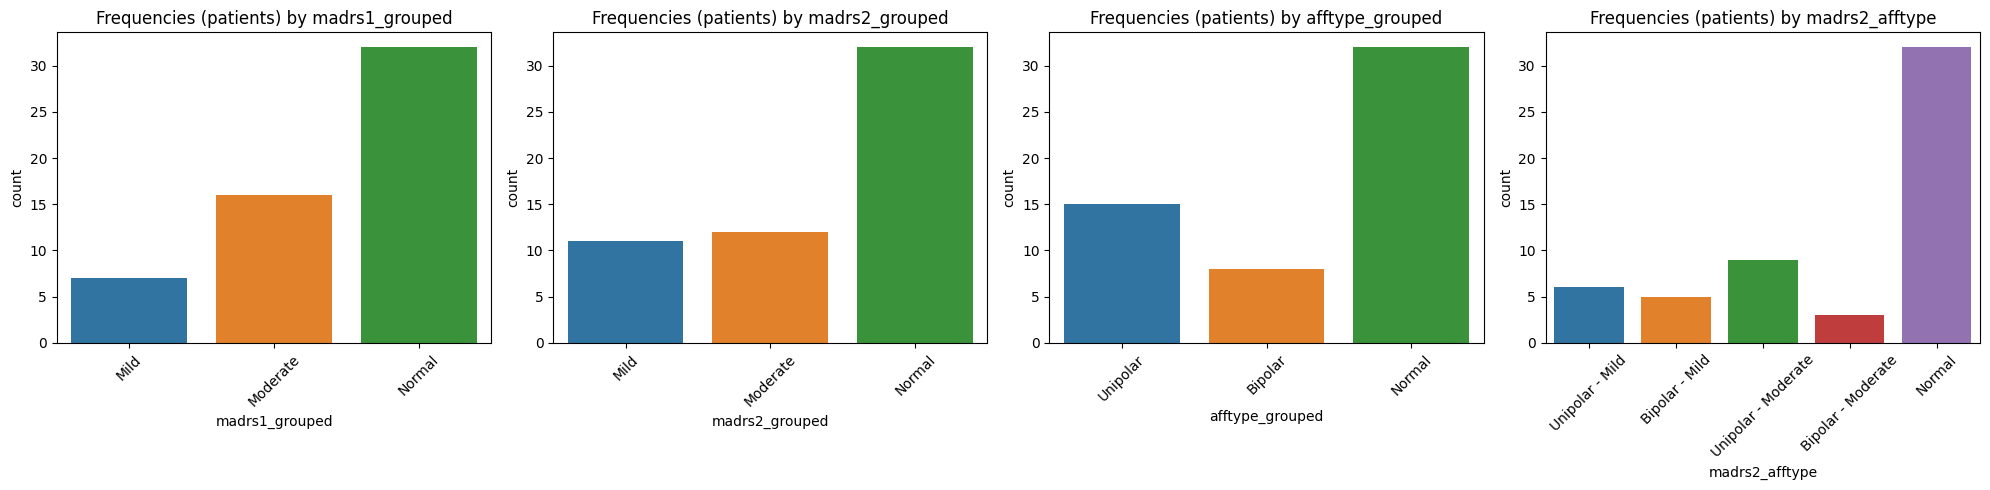

In [20]:
plot_frequencies(df_patients, ['madrs1_grouped', 'madrs2_grouped', 'afftype_grouped', 'madrs2_afftype'], 1, 4, (20, 5), title="Frequencies (patients) by ")

### Load time series motor activity data

In [21]:
def consolidate_csv_files(condition_directory, control_directory):
    """
    Loads all CSV files in the condition and control directories into a single DataFrame.

    Params:
        condition_directory: The directory containing the condition CSV files
        control_directory: The directory containing the control CSV files

    Returns:
        A DataFrame containing all of the data from the CSV files in the condition and control directories
    """
    
    # Create an empty DataFrame to store the consolidated data
    df = pd.DataFrame()

    # Get a list of all files in the condition directory
    condition_files = os.listdir(condition_directory)

    # Iterate over each condition file
    for condition_file in condition_files:
        # Extract the number from the filename
        number = condition_file.replace('condition_', '').replace('.csv', '')
        # Read the condition file into a DataFrame
        condition_data = pd.read_csv(os.path.join(condition_directory, condition_file))
        # Add the 'number' column to the condition data
        condition_data['number'] = 'condition_' + str(number)
        # Append the condition data to the consolidated data
        df = pd.concat([df, condition_data], ignore_index=True)

    # Get a list of all files in the control directory
    control_files = os.listdir(control_directory)

    # Iterate over each control file
    for control_file in control_files:
        # Extract the number from the filename
        number = control_file.replace('control_', '').replace('.csv', '')
        # Read the control file into a DataFrame
        control_data = pd.read_csv(os.path.join(control_directory, control_file))
        # Add the 'number' column to the control data
        control_data['number'] = 'control_' + str(number)
        # Append the control data to the consolidated data
        df = pd.concat([df, control_data], ignore_index=True)

    # Change timestamp and date to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = pd.to_datetime(df['date'])

    # Sort by number and timestamp
    df = df.sort_values(by=['number', 'timestamp'])

    # Reindex
    df = df.reset_index(drop=True)

    return df

df_motor = consolidate_csv_files(raw_condition_path, raw_control_path)

# Check that the number of distinct 'number' in df_motor is equal to the number of distinct 'number' in df_patients
assert len(df_motor['number'].unique()) == len(df_patients['number'].unique())

### Merge patient-level and time-series data

In [22]:
# Merge the patient-level data with the time-series data
df_merged = pd.merge(df_patients, df_motor, on=['number'])

# Check correct number of rows
assert len(df_merged) == len(df_motor) # Check that the number of rows in the merged DataFrame is the same as the number of rows in the time-series data
assert len(df_merged['number'].unique()) == len(df_motor['number'].unique()) # Check that the number of distinct 'number' in the merged DataFrame is the same as the number of distinct 'number' in the time-series data
assert len(df_merged['number'].unique()) == len(df_patients['number'].unique()) # Check that the number of distinct 'number' in the merged DataFrame is the same as the number of distinct 'number' in the patient-level data

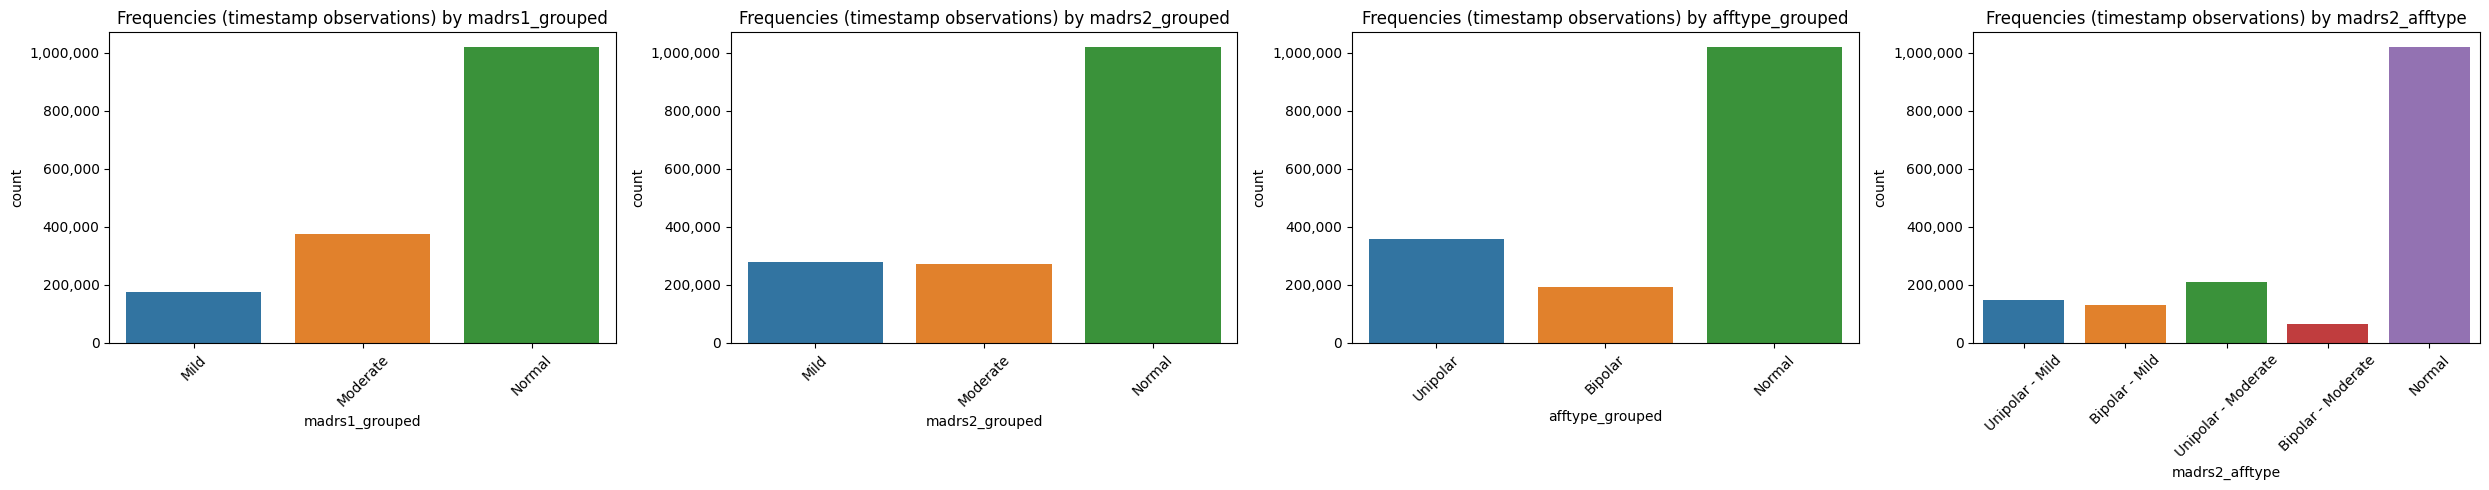

In [23]:
plot_frequencies(df_merged, ['madrs1_grouped', 'madrs2_grouped', 'afftype_grouped', 'madrs2_afftype'], 1, 4, (25, 5), title="Frequencies (timestamp observations) by ")

We will be using madrs2_grouped as the label as it has the least class imbalance.

### Derive date-time values from timestamp

In [24]:
def calculate_time_features(df):
    """
    Calculate minute of day, minute of week, minute, hour, day, day of week,
    week of year, month, year, minute after first, hour after first, and day after first
    from the timestamp column in the given dataframe.

    Args:
        df: dataframe with a 'timestamp' column

    Returns:
        A new dataframe with the added time features
    """
    # Calculate time fields
    df['minute_of_day'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute
    df['minute_of_week'] = df['timestamp'].dt.dayofweek * 24 * 60 + df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute
    df['minute'] = df['timestamp'].dt.minute
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    df['minute_after_first'] = df.groupby('number')['timestamp'].rank(method='first')-1
    df['hour_after_first'] = df['minute_after_first'] // 60
    df['day_after_first'] = df['hour_after_first'] // 24

    # QC checks

    # Assert that minute of day is between 0 and 1439
    assert df['minute_of_day'].min() >= 0
    assert df['minute_of_day'].max() <= 1439

    # Assert that for each number, the minimum minute_after_first, hour_after_first is 0
    assert df.groupby('number')['minute_after_first'].min().min() == 0
    assert df.groupby('number')['hour_after_first'].min().min() == 0
    assert df.groupby('number')['day_after_first'].min().min() == 0
    
    return df
  
df_merged = calculate_time_features(df_merged)

### Remove rows with invalid timestamps

In [25]:
# Remove rows where day_after_first is greater than 'days'
print("Rows before removing rows where day_after_first is greater than 'days':", df_merged.shape[0])
df_merged = df_merged[df_merged['day_after_first'] <= df_merged['days']]
print("Rows after removing rows where day_after_first is greater than 'days':", df_merged.shape[0])

Rows before removing rows where day_after_first is greater than 'days': 1571706
Rows after removing rows where day_after_first is greater than 'days': 1077120


In [26]:
# plot_activity_by_hour(df_merged, 'hour_after_first')

### Visualise distribution of activity by time and group

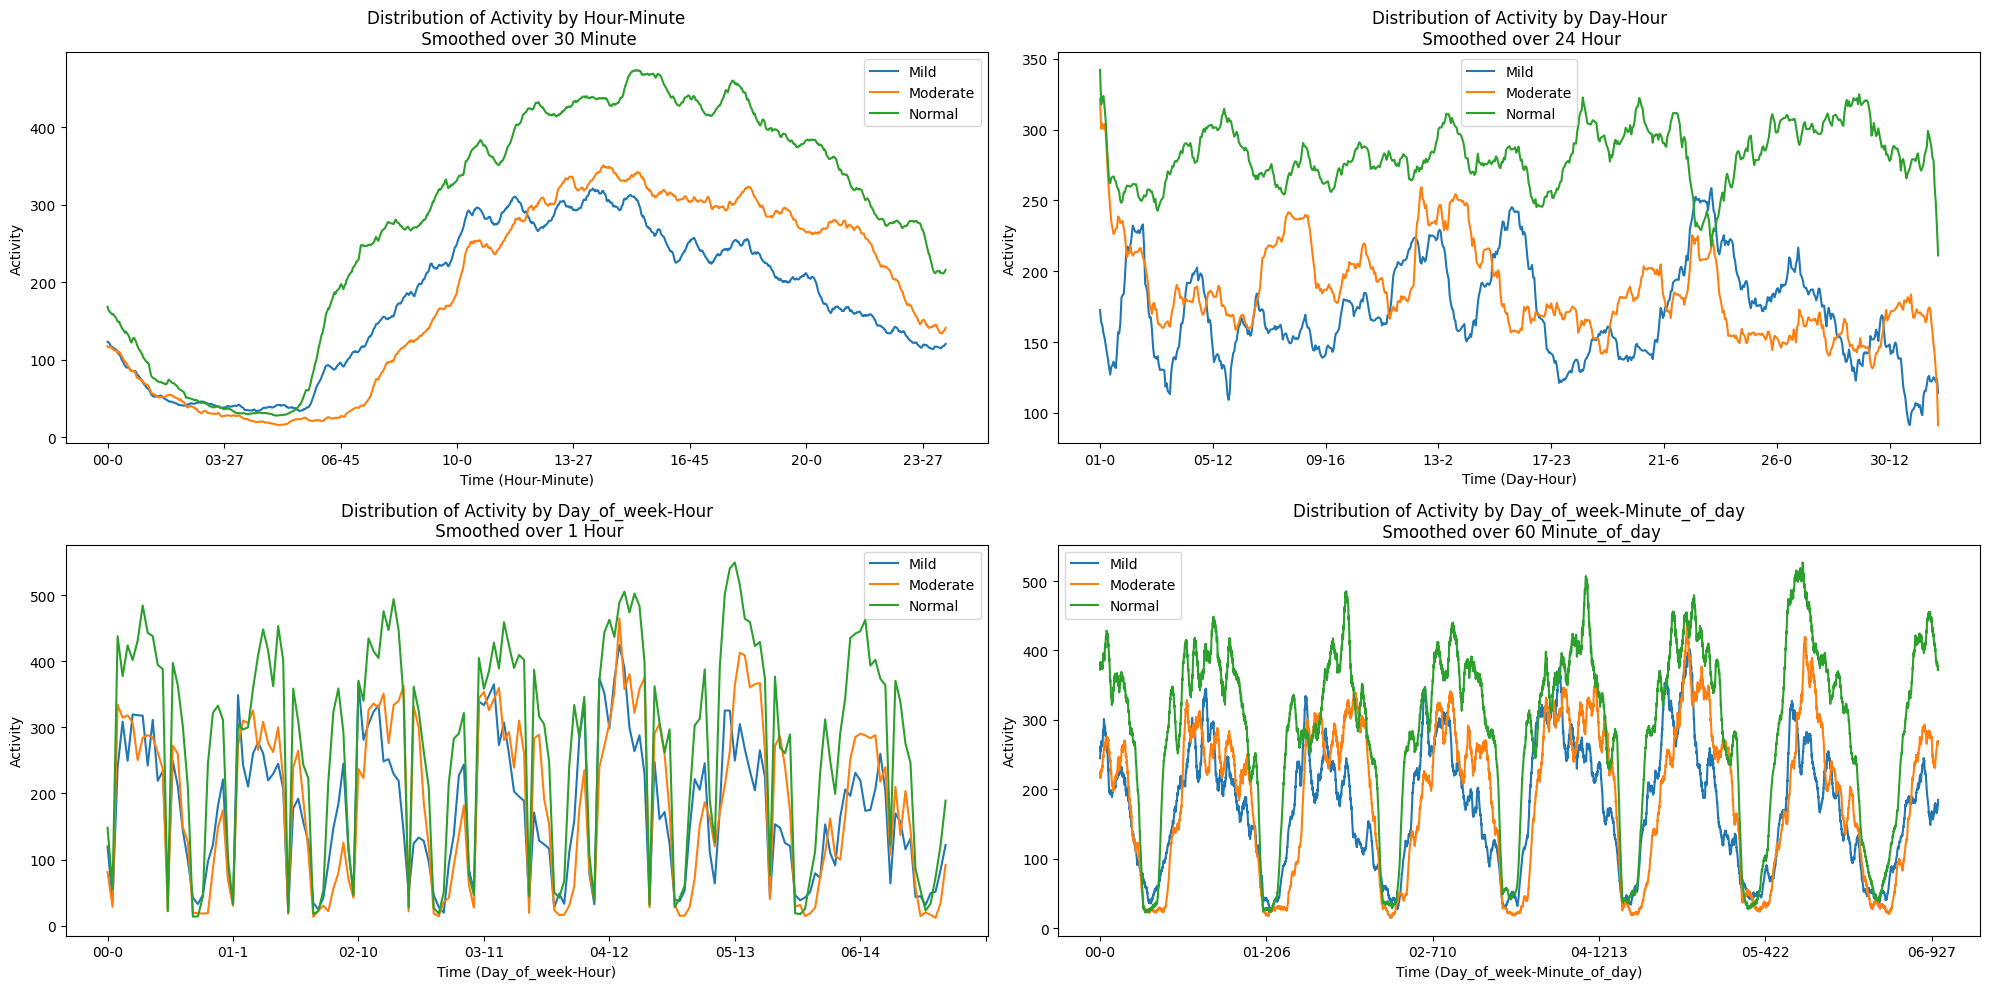

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axs = axs.ravel()

time_activity_plot_combo(df_merged, 'hour', 'minute', 30, axs[0]) # Smooth over 30 minutes
time_activity_plot_combo(df_merged, 'day', 'hour', 24, axs[1]) # Smooth over 24 hours
time_activity_plot_combo(df_merged, 'day_of_week', 'hour', 1, axs[2]) # No smoothing
time_activity_plot_combo(df_merged, 'day_of_week', 'minute_of_day', 60, axs[3]) # Smooth over 60 minutes

plt.tight_layout()

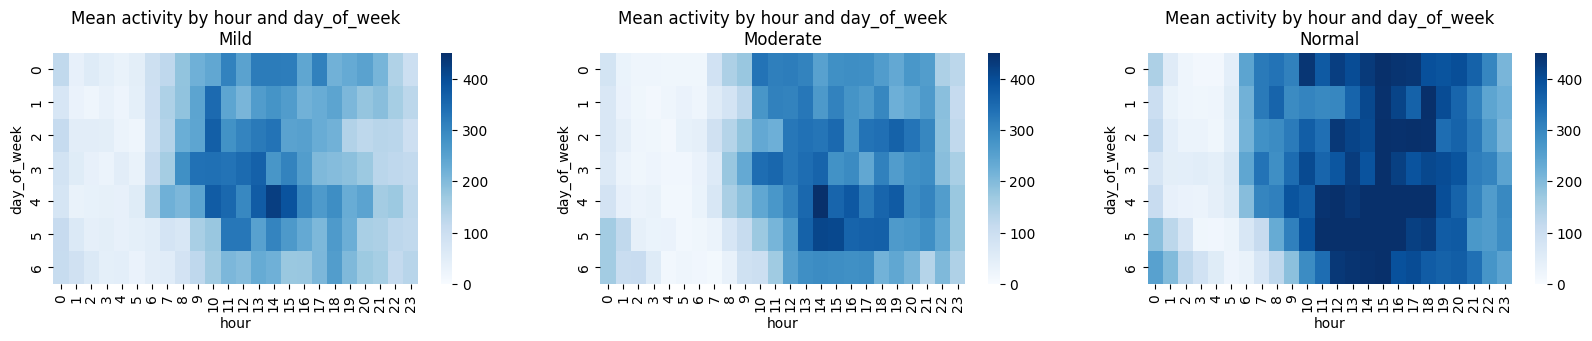

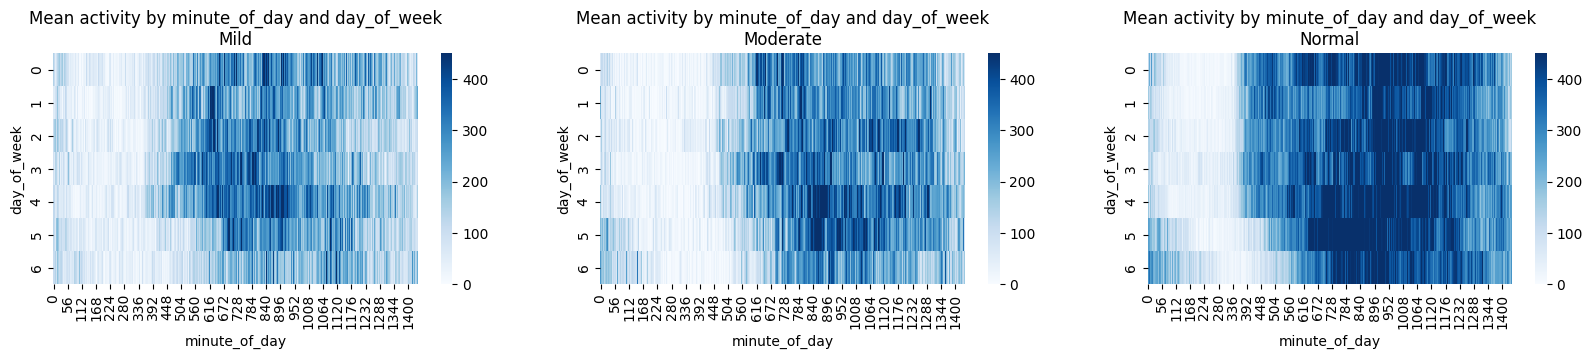

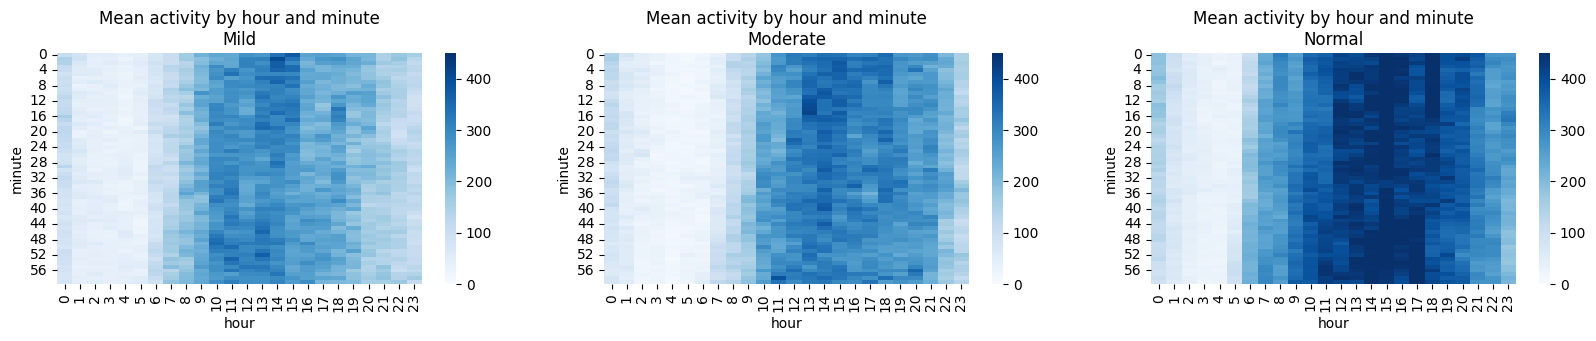

In [28]:
plot_activity_heatmap(df_merged, 'hour', 'day_of_week')
plot_activity_heatmap(df_merged, 'minute_of_day', 'day_of_week')
plot_activity_heatmap(df_merged, 'hour', 'minute')

Notes:
- Week of year or month doesn't seem to be meaningful
- Cyclicality by day of the week and hour/minute of day - potentially could derive parameters for a sin/cos equation as features?
- Moderate patients seem to start being active in the day later
- Both mild and moderate depression patients have a shorter window of time during the day when they are active
- Bigger variation in activity between days of the week for depressed patients
- Peak activity by hour is equal across the groups
- Given most patient's activity is in the 11-13 day mark, analysis should be on a day_of_week or hourly or minute level
- Patterns differ by day of the week. May need to extract features by minute depending on day of the week

### Add one hot and ordinal encodings for madrs2_grouped to df_merged

In [29]:
# Add one hot encoding for madrs2_grouped while keeping original column
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['madrs2_grouped'])], axis=1)

# Add ordinal encodings where normal = 0, mild = 1, and moderate = 2
madrs2_group_mapping = {'Normal': 0,
                        'Mild': 1,
                        'Moderate': 2}

df_merged['madrs2_grouped_ord'] = df_merged['madrs2_grouped'].map(madrs2_group_mapping)

### Data Subject Alignment

To ensure data consistency across subjects, we will perform an analysis of the most recent seven complete days of activity readings.

#### Functions

In [30]:
def remove_partial_days(filtered_df):
    """If active, will remove days that do not have 1440 recordings per day"""    
    # Group by to find days and months for each person that does not contain 1440 recordings
    temp_df=filtered_df.groupby(['number','month','day']).count().reset_index()
    temp_df=temp_df.loc[temp_df['days']!=1440]

    # Create an array with array of number, day, and month that do not have 1440 recordings
    to_delete=np.array([temp_df.number.values,temp_df.month.values,temp_df.day.values])

    for i in range(to_delete.shape[1]):
        td_number=to_delete[0][i]
        td_month=to_delete[1][i]
        td_day=to_delete[2][i]

        filtered_df=filtered_df.loc[~((filtered_df.number==td_number) &\
                                      (filtered_df.month==td_month) & (filtered_df.day==td_day))]
        
    return filtered_df

def return_dictionary_of_split_days(temp_df,split):
    """Function creates a dictionary of users and split number of days (starting at end of time-series)"""
    # Create dictionary of users and their last seven days
    new_group_days={num:(np.array(temp_df.loc[temp_df.number==num].day.unique())[-split:])
                                        for num in temp_df.number.unique()}

    return new_group_days

def create_new_split(temp_df,splits_dict,suffix):   
    """Filter to keep only rows that match number and day for groupA and assign to new df"""
    for key,value in splits_dict.items():
        temp_df=temp_df.loc[~((temp_df.number==key) & (~temp_df.day.isin(value)))]
        
    #add a suffix
    temp_df.loc[:,'number']=temp_df.number+suffix
        
    return temp_df

def remove_users(temp_df,splits_dict):
    """Filter out the newly pulled users and days from df_edit"""
    for key,value in splits_dict.items():
        temp_df=temp_df.loc[~((temp_df.number==key) & (temp_df.day.isin(value)))]

    return temp_df

#### Split subject time-series to find last seven days

In [31]:
#----------------------------------------
#SET PARAMETERS for how to segment subject
#----------------------------------------
split=7 #split users into groups containing this number of days
remove_partial=True #if true, remove days without 1440 active readings

#----------------------------------------
#RUN MAIN CODE to SPLIT USERS
#----------------------------------------
def split_users(df=df_merged):
    """
    Split users (patients) into groups of split days. If remove_partial is True, remove days that do not have 1440 readings per day.
    
    Params:
        df: dataframe to split users on
    
    Returns:
        A dataframe with users split into groups of split days
    """

    #suffix to append to newly created users (ex: control_1 -> control_1B)
    user_suffix = np.array([chr(i) for i in range(ord('a'), ord('z') + 1)])

    #remove days without 1440 readings
    if (remove_partial==True):
        df_edit=remove_partial_days(df)
    else:
        df_edit=df

    #Initiate new data frame to split users
    df_splits=pd.DataFrame({})

    #loop through and create new groups based on user inputed split
    i=0
    while len(df_edit) != 0:

        #return a dictionary of split # of days for remaining users
        splits_dict=return_dictionary_of_split_days(df_edit,split)
        
        #take new split of users and days and add it to the splits_df
        df_splits=pd.concat([df_splits,create_new_split(df_edit,splits_dict,user_suffix[i])])
        
        #filter out the newly pulled users and days from df_edit
        df_edit=remove_users(df_edit,splits_dict)

        i+=1

    # Sort new data set
    df_splits = df_splits.sort_values(['number', 'date'], ascending=[True, True])

    # Reset index
    df_splits = df_splits.reset_index(drop=True)
    
    print(f'Number of Users Total: {len(df_splits.number.unique())}')
    return df_splits

df_splits = split_users(df=df_merged)
df_splits.head()

Number of Users Total: 113


number  days gender    age afftype melanch inpatient   edu marriage  \
0  condition_10a   9.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
1  condition_10a   9.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
2  condition_10a   9.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
3  condition_10a   9.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
4  condition_10a   9.0      2  45-49     2.0     2.0       2.0  6-10      1.0   

  work  ...  month  year minute_after_first hour_after_first day_after_first  \
0  2.0  ...      9  2004             3780.0             63.0             2.0   
1  2.0  ...      9  2004             3781.0             63.0             2.0   
2  2.0  ...      9  2004             3782.0             63.0             2.0   
3  2.0  ...      9  2004             3783.0             63.0             2.0   
4  2.0  ...      9  2004             3784.0             63.0             2.0   

   time   Mild Moderate  Normal  madrs2_grouped_ord  
0  04-0  False     True   False                   2  
1  04-1  False     True   False                   2  
2  04-2  False     True   False                   2  
3  04-3  False     True   False                   2  
4  04-4  False     True   False                   2  

[5 rows x 36 columns]

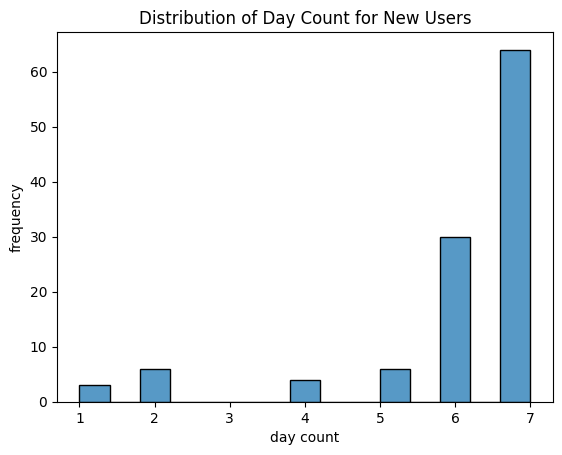

In [32]:
#Distribution of Day Count for New Users
sns.histplot(df_splits.groupby(['number','day']).count().reset_index().groupby('number').count().reset_index()['day'])
plt.xlabel('day count')
plt.ylabel('frequency')
plt.title('Distribution of Day Count for New Users')
plt.show()

In [33]:
def drop_users_missing_days(df_splits=df_splits, missing_days_allowed=0):
    """
    Drops users with missing days

    Params:
        df_splits: dataframe with 'split' users split into groups of 'split' days
        missing_days_allowed: number of missing days allowed.

    Returns:
        A dataframe with users with missing days dropped
    """
    # Print the number of users before dropping users with missing days
    print(f'Number of Users Before Dropping Users with Missing Days: {len(df_splits.number.unique())}')
    
    # Find users with more than the alloted number of missing days
    temp_df=df_splits.groupby(['number','day']).count().reset_index().groupby(['number']).count()
    users_with_too_few_days=temp_df.loc[temp_df.day<split-missing_days_allowed].reset_index().number

    # Drop users with too few days
    df_splits=df_splits.loc[~df_splits.number.isin(users_with_too_few_days)]

    # Print number of users remaining
    print(f'Number of Users Remaining: {len(df_splits.number.unique())}')

    # Reset index
    df_splits = df_splits.reset_index(drop=True)
    return df_splits

df_splits = drop_users_missing_days(df_splits=df_splits, missing_days_allowed=0)

Number of Users Before Dropping Users with Missing Days: 113
Number of Users Remaining: 64


In [34]:
#only maintain subjects latest week of activity readings
df_splits=df_splits.loc[df_splits.number.str.contains('a')]
df_splits.number.value_counts()

number
condition_10a    10080
control_27a      10080
control_17a      10080
control_18a      10080
control_19a      10080
control_1a       10080
control_20a      10080
control_21a      10080
control_22a      10080
control_23a      10080
control_24a      10080
control_25a      10080
control_26a      10080
control_28a      10080
condition_11a    10080
control_29a      10080
control_2a       10080
control_30a      10080
control_31a      10080
control_32a      10080
control_3a       10080
control_4a       10080
control_5a       10080
control_6a       10080
control_7a       10080
control_8a       10080
control_16a      10080
control_15a      10080
control_14a      10080
control_13a      10080
condition_12a    10080
condition_13a    10080
condition_14a    10080
condition_15a    10080
condition_16a    10080
condition_17a    10080
condition_18a    10080
condition_19a    10080
condition_1a     10080
condition_20a    10080
condition_21a    10080
condition_22a    10080
condition_23a    10080
cond

#### Recalculate date-time values from timestamp

In [35]:
# Calculate time columns (e.g., minute_after_first, hour_after_first, day_after_first)
df_splits = calculate_time_features(df_splits)

# Set 'days' column to be the maximum day_after_first for each number + 1 (since day_after_first is based on 0-indexing)
df_splits['days'] = df_splits.groupby('number')['day_after_first'].transform('max')+1

df_splits.head()

number  days gender    age afftype melanch inpatient   edu marriage  \
0  condition_10a   7.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
1  condition_10a   7.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
2  condition_10a   7.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
3  condition_10a   7.0      2  45-49     2.0     2.0       2.0  6-10      1.0   
4  condition_10a   7.0      2  45-49     2.0     2.0       2.0  6-10      1.0   

  work  ...  month  year minute_after_first hour_after_first day_after_first  \
0  2.0  ...      9  2004                0.0              0.0             0.0   
1  2.0  ...      9  2004                1.0              0.0             0.0   
2  2.0  ...      9  2004                2.0              0.0             0.0   
3  2.0  ...      9  2004                3.0              0.0             0.0   
4  2.0  ...      9  2004                4.0              0.0             0.0   

   time   Mild Moderate  Normal  madrs2_grouped_ord  
0  04-0  False     True   False                   2  
1  04-1  False     True   False                   2  
2  04-2  False     True   False                   2  
3  04-3  False     True   False                   2  
4  04-4  False     True   False                   2  

[5 rows x 36 columns]

## Step 2: Feature Extraction

### Extract features from time series data

We will extract the following features, based on rationale from literature:

1. **Interdaily stability**: Interdaily stability is a measure of the strength of circadian rhythmicity, the degree of consistency of activity patterns from one day to the next. It is calculated as the ratio of the variance of the average 24-hour pattern around the mean to the overall variance. This feature has been found to be useful in discriminating between depressed patients and healthy controls[1][2][3][4]. A study found that depressed patients had lower interdaily stability compared to healthy controls, indicating a less stable activity pattern[1].

1. **Intraday variability**: Intraday variability is a measure of the variability of the activity level within a day. It quantifies the frequency and extent of transitions between periods of rest and activity on an hourly basis. High intraday variability values indicate the occurrence of daytime naps and/or nocturnal activity episodes. This feature has been found to be useful in discriminating between depressed patients and healthy controls[3]. A study found that depressed patients had higher intraday variability compared to healthy controls, indicating a more fragmented activity pattern[3].

1. **Statistical metrics for activity levels**: These features capture different aspects of the activity level of the patients, such as mean activity, standard deviation of activity, skewness of activity, kurtosis of activity, and entropy of activity. They have been found to be useful in discriminating between depressed patients and healthy controls[1][5][3]. For example, a study found that depressed patients had lower mean activity levels and higher variability of activity levels compared to healthy controls, indicating a less active lifestyle[5].

1. **Distribution of activity occurring at different times**: This feature captures the distribution of activity occurring at different times, such as day vs. night and weekday vs. weekend. It has been found to be important for accurately classifying depression status, as there are differences in activity patterns between these periods[1][3][4]. For example, a study found that depressed patients had lower activity levels during the day and higher activity levels during the night compared to healthy controls, indicating a disrupted circadian rhythm[4].

1. **Cosine function parameters for activity**: Cosine function parameters, including amplitude, phase, baseline, and frequency, could be useful features in analyzing time series motor actigraphy data to classify patients into normal, mild, or moderate depression. Cosine models are used to map the circadian activity rhythm to activity data, and the evaluation of circadian rhythms typically involves determining the amplitude and phase of the rhythm per cycle using methods such as cosine fitting. [6][7][8]

1. **Statistical metrics for activity bouts and inactivity bouts**: These features capture different aspects of the activity patterns of the patients, such as the number of bouts, mean bout duration, standard deviation of bout duration, skewness of bout duration, kurtosis of bout duration, and entropy of bout duration. They have been found to be useful in discriminating between depressed patients and healthy controls[1][5][3]. For example, a study found that depressed patients had fewer and longer bouts of activity compared to healthy controls, indicating a less active lifestyle[5].


Overall, these features capture different aspects of the activity patterns and levels of the patients, and have been found to be useful in discriminating between depressed patients and healthy controls using machine learning algorithms. Interdaily stability and intraday variability are particularly relevant for discriminating between mildly depressed and moderately depressed patients, as they capture the stability and variability of the activity pattern over multiple days and within a day, respectively.

Note that statistical metrics will include:
1. Number of bouts: Captures the number of distinct periods of activity and inactivity throughout the day
1. Mean (of bout duration / activity levels)
1. Standard deviation (of bout duration / activity levels)
1. Coefficient of variation (of bout duration / activity levels): Standard deviation / mean - corrects for differences in mean by patient
1. Skewness (of bout duration / activity levels): Measures asymmetry of the distribution
1. Kurtosis (of bout duration / activity levels): Measures peakedness of distribution
1. Entropy (of bout duration / activity levels): Measures complexity of the distribution

Citations:
[1] https://www.radc.rush.edu/docs/var/detail.htm?category=Sleep+and+Circadian+Rhythms&subcategory=Sensor+device+measures&variable=is
[2] https://sleepscience.org.br/details/527/en-US/a-nonparametric-methodological-analysis-of-rest-activity-rhythm-in-type-2-diabetes
[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4559593/
[4] https://pure.uva.nl/ws/files/1216705/2123_22039y.pdf
[5] https://www.researchgate.net/publication/271767741_Nonparametric_methods_in_actigraphy_An_update
[6] https://tbiomed.biomedcentral.com/articles/10.1186/1742-4682-11-16
[7] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6857846/
[8] https://www.frontiersin.org/articles/10.3389/fnins.2023.1173537/full

#### Set the input dataframe for feature extraction

In [36]:
df_feature_input = df_splits.copy()

#### Activity-level features

In [37]:
def cosinor(x, amplitude, frequency, phase, baseline):
    return amplitude * np.cos(2 * np.pi * frequency * x + phase) + baseline

def fit_cosinor(df, x_col, y_col):
    """
    Fits a cosinor curve to the data and returns the parameters.
    """
    x = df[x_col]
    y = df[y_col]

    # Make initial guess
    guess_amplitude = np.std(y) * (2**0.5)
    guess_phase = 0
    guess_frequency = 1
    guess_baseline = np.mean(y)
    guess = [guess_amplitude, guess_phase, guess_frequency, guess_baseline]

    # Fit the function
    params, params_covariance = curve_fit(cosinor, x, y, p0=guess, maxfev=5000)
    amplitude, phase, frequency, baseline = params
    
    return {
        f'cos_{x_col}_amplitude': amplitude,
        f'cos_{x_col}_phase': phase,
        f'cos_{x_col}_frequency': frequency,
        f'cos_{x_col}_baseline': baseline,
    }

def interday_stability(data):
    """
    Calculates interday stability, which quantifies the variability of patterns within a 24-hour cycle across multiple days
    Interday Stability = Variance of the average 24 hour pattern / Total Variance of the Group
    """
    # Calculate average 24-hour pattern for the group
    mean_24h_pattern = data['activity'].groupby([data.timestamp.dt.hour]).mean()

    # Calculate variance of the average 24-hour pattern
    var_24h_pattern = np.var(mean_24h_pattern)

    # Calculate total variance of the group
    total_var = np.var(data['activity'])

    # Calculate Interdaily Stability for the group
    interday_stability = var_24h_pattern / total_var

    return interday_stability

def intraday_variability(data):
    """
    Calculates intraday variability, which represents the level of variability within a single day relative to average activity level for that day
    Intraday Variability = Variance of activity values within a single day / Mean activity value for that day
    """
    # Group the data by date and calculate the variance within each day
    daily_variances = data.groupby(data.timestamp.dt.date)['activity'].var()

    # Calculate the mean activity value for each day
    daily_means = data.groupby(data.timestamp.dt.date)['activity'].mean()

    # Calculate the intraday variability by dividing the daily variances by the daily means
    intraday_variability = np.mean(daily_variances / daily_means)

    return intraday_variability

def pct_day_activity(data, hour_start, hour_end):
    """
    Calculate the percentage of activity occurring in a time window (e.g., 08:00-12:00)
    """
    # Calculate sum of activity
    total_activity = data['activity'].sum()
    
    if hour_start < hour_end:
        window_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].sum()
    else: 
        window_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].sum()

    # Calculate percentage of activity during each window
    pct_activity = window_activity / total_activity if total_activity > 0 else 0

    return pct_activity

def pct_weekday_activity(data):
    """
    Calculate the percentage of activity occurring in weekdays
    """
    # Calculate sum of activity
    total_activity = data['activity'].sum()

    window_activity = data[data['timestamp'].dt.dayofweek.between(0,4)]['activity'].sum()

    # Calculate percentage of activity during selected days
    pct_activity = window_activity / total_activity if total_activity > 0 else 0

    return pct_activity

def mean_activity_window(data, hour_start, hour_end, weekdays=True):
    """
    Calculate mean activity during a time window (e.g., 08:00-12:00) for specific days of the week
    (e.g., weekdays, weekends, Mondays, Tuesdays, etc.)
    """
    if weekdays:
        # filter data to only include weekdays
        data = data[data['timestamp'].dt.dayofweek.between(0, 4)]
        if hour_start < hour_end:
            mean_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].mean()
        else:
            mean_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].mean()
    else:
        # filter data to only include weekends
        data = data[data['timestamp'].dt.dayofweek.between(5, 6)]
        if hour_start < hour_end:
            mean_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].mean()
        else:
            mean_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].mean()

    return mean_activity

In [38]:
def calculate_activity_features(data):
    """
    Group data by number and calculate activity-based features for each number
    """
    # ignore the specific warning:
    warnings.filterwarnings("ignore")
    
    # Create an empty DataFrame to store the features
    df = pd.DataFrame()

    # Get madrs2_grouped values for each number
    df['madrs2_grouped'] = data.groupby('number')['madrs2_grouped'].first()
    df['madrs2_grouped_ord'] = data.groupby('number')['madrs2_grouped_ord'].first()
    df['Normal'] = data.groupby('number')['Normal'].first()
    df['Mild'] = data.groupby('number')['Mild'].first()
    df['Moderate'] = data.groupby('number')['Moderate'].first()
       
    # Interday stability
    df['activity_interday_stability'] = data.groupby('number').apply(interday_stability)
    
    # Intradaily variability
    df['activity_intraday_variability'] = data.groupby('number').apply(intraday_variability)

    # Mean activity
    df['activity_mean'] = data.groupby('number')['activity'].mean()

    # Mean activity for different times of the week
    # Create a for loop to calculate mean activity for different times of the week
    for weekdays in [True, False]:
        for hour_start, hour_end in [(0, 6), (6, 12), (12, 18), (18, 0)]:
            if weekdays:
                df[f'activity_mean_weekdays_{hour_start}to{hour_end}'] = data.groupby('number').apply(lambda x: mean_activity_window(x, hour_start=hour_start, hour_end=hour_end, weekdays=weekdays))
            else:
                df[f'activity_mean_weekends_{hour_start}to{hour_end}'] = data.groupby('number').apply(lambda x: mean_activity_window(x, hour_start=hour_start, hour_end=hour_end, weekdays=weekdays))

    # Standard deviations of activity level
    df['activity_std_minutely'] = data.groupby('number')['activity'].std()
    df['activity_std_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].var().groupby('number').std()
    df['activity_std_daily'] = data.groupby(['number', 'day_after_first'])['activity'].var().groupby('number').std()

    # Coefficient of variation of activity level
    df['activity_cv_minutely'] = df['activity_std_minutely'] / df['activity_mean']
    df['activity_cv_hourly'] = df['activity_std_hourly'] / df['activity_mean']
    df['activity_cv_daily'] = df['activity_std_daily'] / df['activity_mean']

    # Kurtosis of activity level
    df['activity_kurtosis_minutely'] = data.groupby('number')['activity'].apply(stats.kurtosis)
    df['activity_kurtosis_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.kurtosis).groupby('number').mean()
    df['activity_kurtosis_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.kurtosis).groupby('number').mean()

    # Skewness of activity level
    df['activity_skewness_minutely'] = data.groupby('number')['activity'].apply(stats.skew)
    df['activity_skewness_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.skew).groupby('number').mean()
    df['activity_skewness_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.skew).groupby('number').mean()

    # Entropy of activity level
    df['activity_entropy_minutely'] = data.groupby('number')['activity'].apply(stats.entropy)
    df['activity_entropy_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.entropy).groupby('number').mean()
    df['activity_entropy_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.entropy).groupby('number').mean()

    # Percentage of activity occuring on weekdays
    df['activity_pct_weekday'] = data.groupby('number').apply(pct_weekday_activity)
    
    # Percentage of activity occurring during 12-hour time windows - note to figure out the best splits to maximise the difference between groups
    df['activity_pct_0to6'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 0, 6))
    df['activity_pct_6to12'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 6, 12))
    df['activity_pct_12to18'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 12, 18))
    df['activity_pct_18to0'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 18, 24))
    
    # Apply the cosinor fit function and create a DataFrame with the results use minute_of_day
    cosinor_features = data.groupby('number').apply(fit_cosinor, 'minute_of_day', 'activity')
    cosinor_df = pd.DataFrame(list(cosinor_features.values), index=cosinor_features.index)

    # Concatenate the existing df with the cosinor_df
    df = pd.concat([df, cosinor_df], axis=1)

    # Apply the cosinor fit function and create a DataFrame with the results use day_of_week
    cosinor_features = data.groupby('number').apply(fit_cosinor, 'day_of_week', 'activity')
    cosinor_df = pd.DataFrame(list(cosinor_features.values), index=cosinor_features.index)

    # Concatenate the existing df with the cosinor_df
    df = pd.concat([df, cosinor_df], axis=1)
    
    # Apply the cosinor fit function and create a DataFrame with the results use minute_of_week
    cosinor_features = data.groupby('number').apply(fit_cosinor, 'minute_of_week', 'activity')
    cosinor_df = pd.DataFrame(list(cosinor_features.values), index=cosinor_features.index)

    # Concatenate the existing df with the cosinor_df
    df = pd.concat([df, cosinor_df], axis=1)

    # Convert 'number' to a column header instead of an index
    df = df.reset_index()
    
    return df

In [39]:
df_activity_features = calculate_activity_features(df_feature_input)
df_activity_features.head()

# Assert that the number of distinct 'number' in df_activity_features is the same as the number of distinct 'number' in df_splits
assert len(df_activity_features['number'].unique()) == len(df_feature_input['number'].unique())

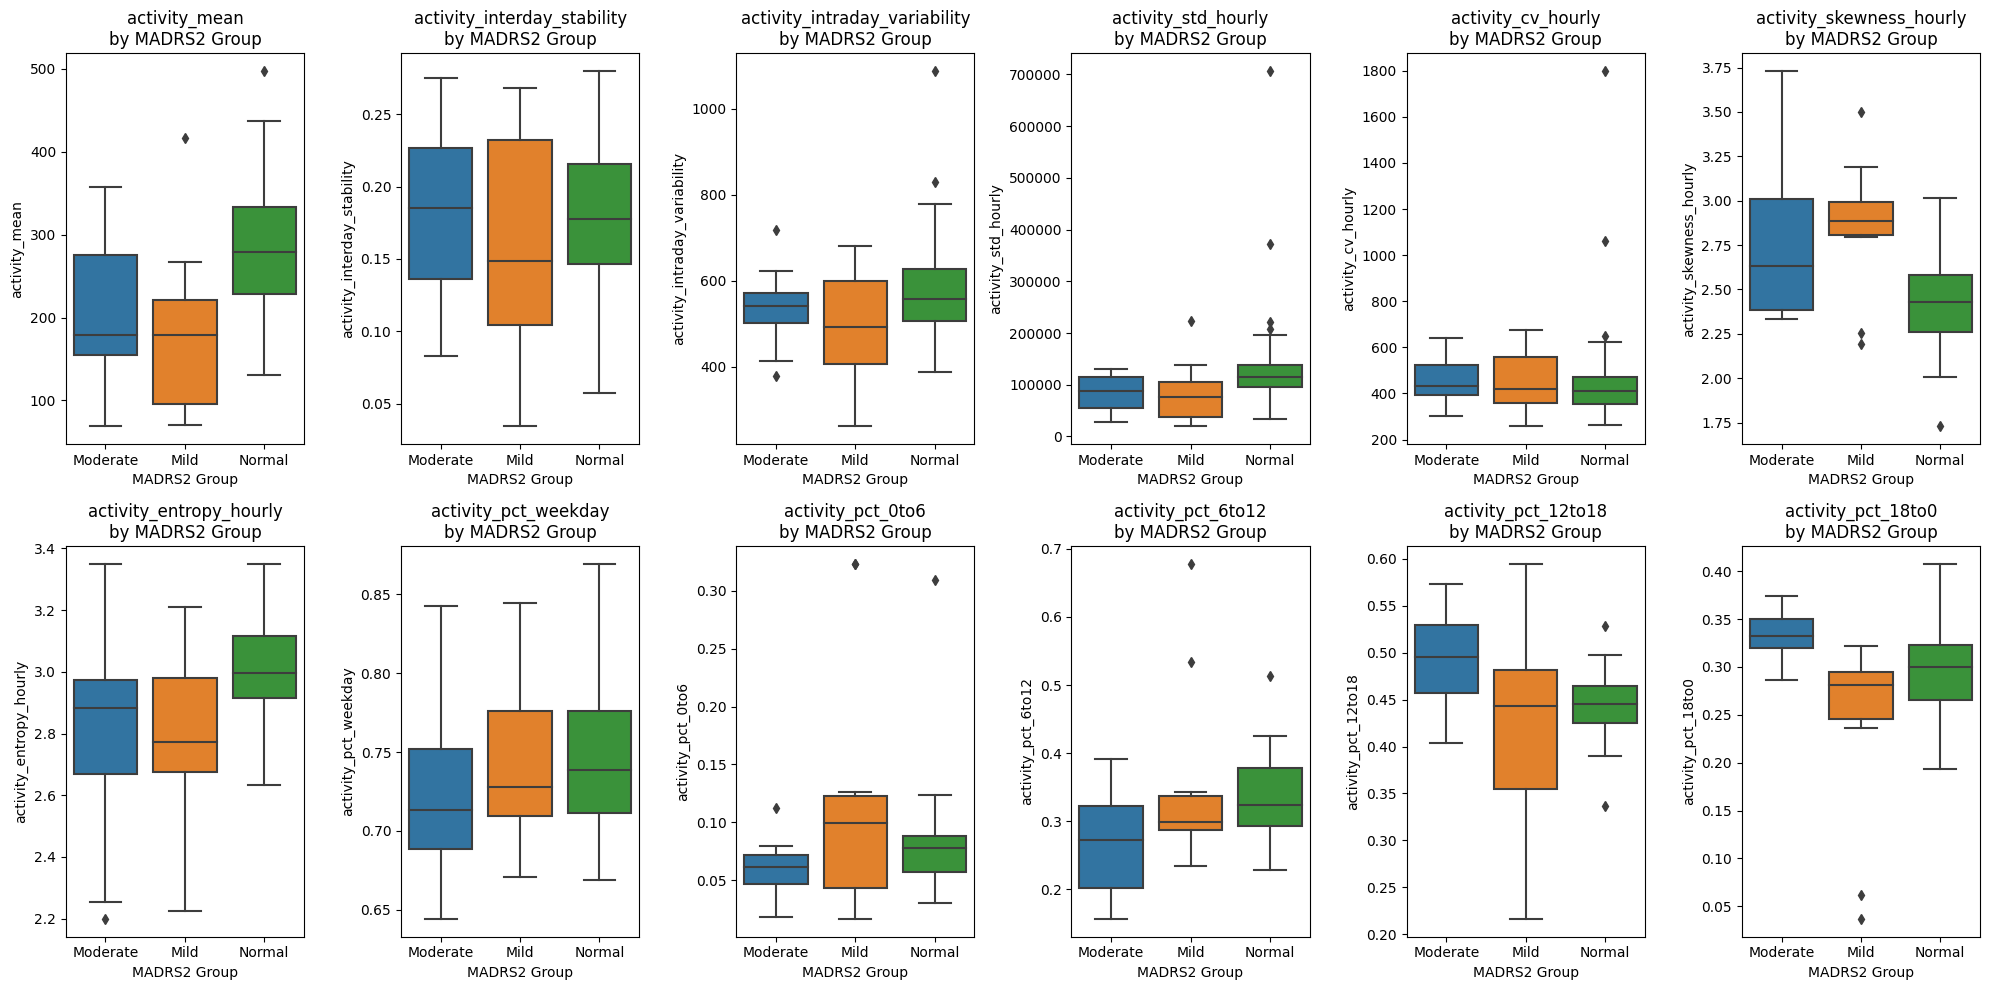

In [40]:
def plot_activity_features(df):
    """Plot boxplots of selected activity features (apart from cosine features)"""
    plot_features(df,
                  rows=2,
                  cols=6,
                  features=['activity_mean',
                            'activity_interday_stability',
                            'activity_intraday_variability',
                            'activity_std_hourly',                                           
                            'activity_cv_hourly',
                            'activity_skewness_hourly',
                            'activity_entropy_hourly',
                            'activity_pct_weekday',
                            'activity_pct_0to6',
                            'activity_pct_6to12',
                            'activity_pct_12to18',
                            'activity_pct_18to0'],
                    figsize=(20, 10))
    
plot_activity_features(df_activity_features)                        

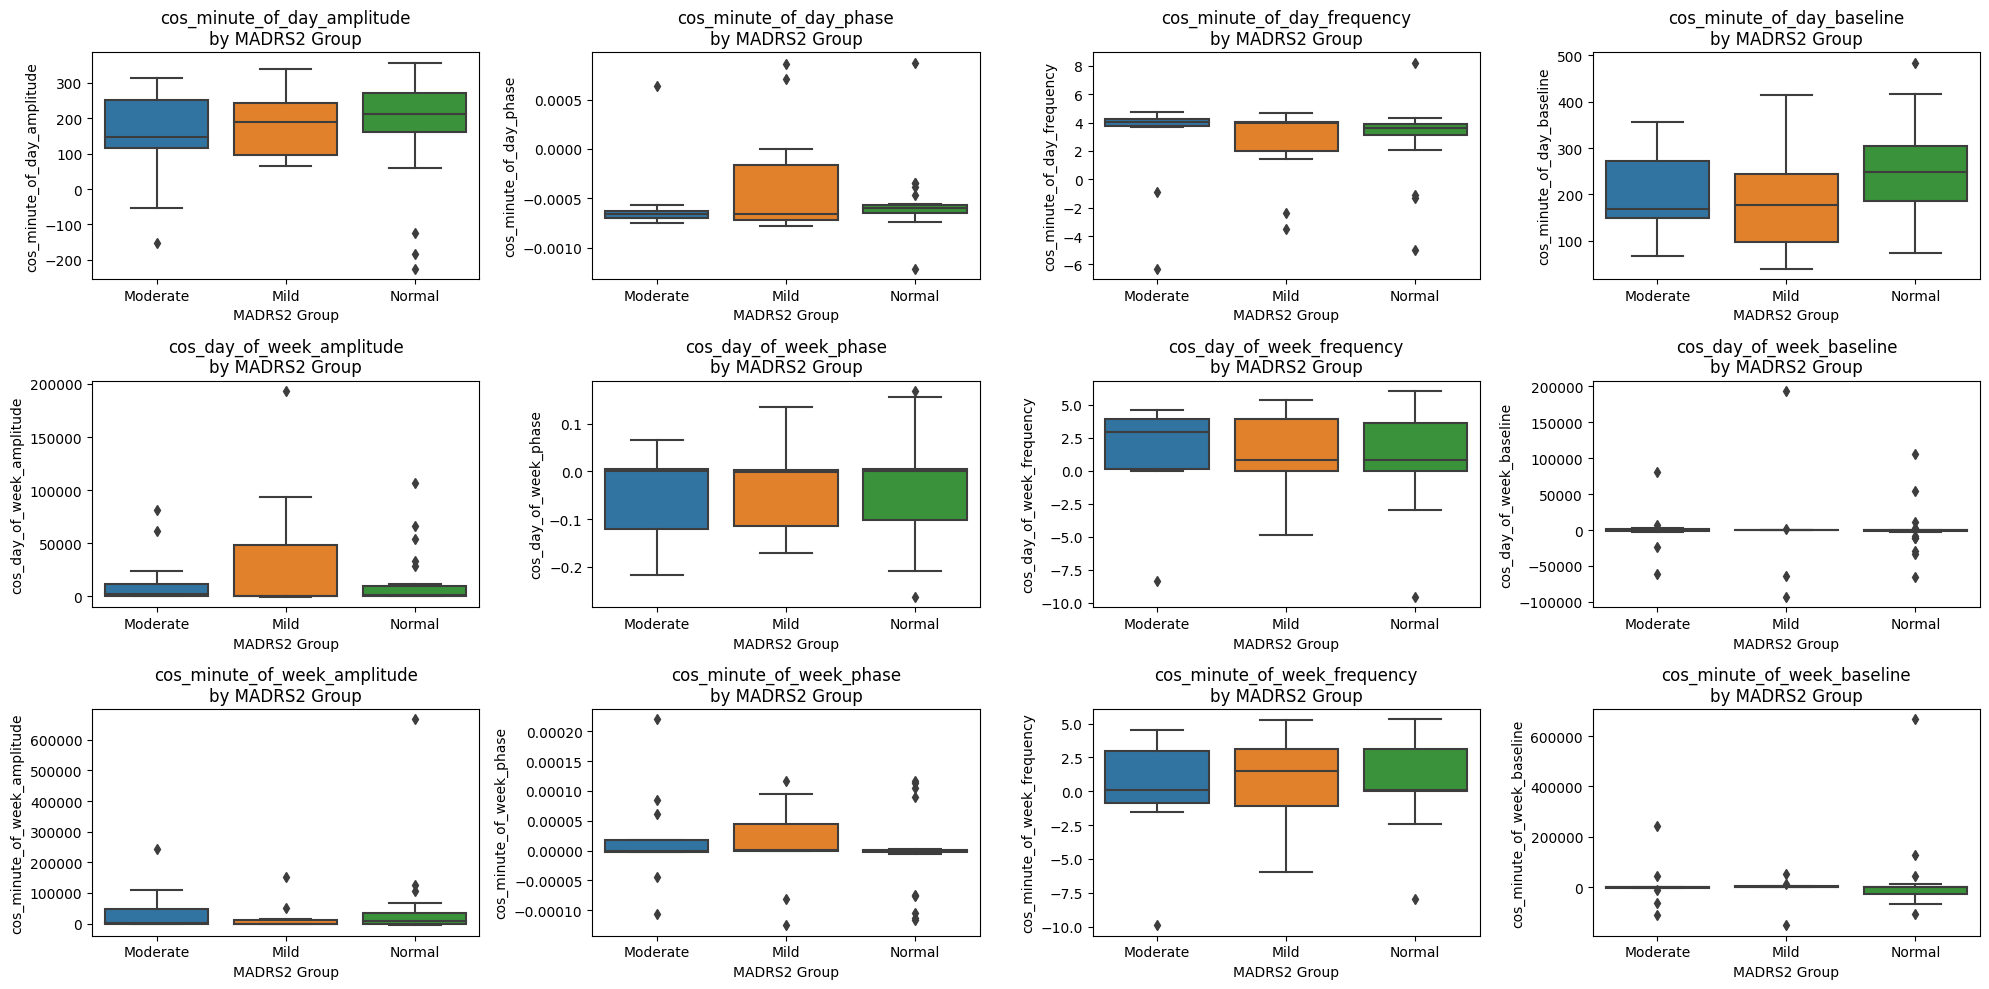

In [41]:
def plot_cos_activity_features(df):
    """Plot boxplots of cosine parameter features"""
    plot_features(df,
                  rows=3,
                  cols=4,
                  features=['cos_minute_of_day_amplitude',
                            'cos_minute_of_day_phase',
                            'cos_minute_of_day_frequency',
                            'cos_minute_of_day_baseline',
                            'cos_day_of_week_amplitude',
                            'cos_day_of_week_phase',
                            'cos_day_of_week_frequency',
                            'cos_day_of_week_baseline',
                            'cos_minute_of_week_amplitude',
                            'cos_minute_of_week_phase',
                            'cos_minute_of_week_frequency',
                            'cos_minute_of_week_baseline'],
                    figsize=(20, 10))
    
plot_cos_activity_features(df_activity_features)

Key findings:
1. Mean activity distinguishes between groups
1. Both interday stability and intraday stability appear to be predictive
1. More meaningful differences for coefficient of variation (cv) than for standard deviation - helps to distinguish between mild and moderate
1. Kurtosis and skewness seem somewhat similar. Distribution of skewness in 'moderate' is such that kurtosis maybe a better metric
1. Distribution of activity in terms of weekend vs. weekday split does not appear to distinguish between groups
1. Distribution of activity in terms of hours distinguishes between groups: Each class appears to have distinct distribution of activity
1. Cosinor parameters differ between the groups, though many overlap with one another

#### Activity/Inactivity Bout Features

To calculate features based on activity/inactivity bouts, we need to first create new dataframes where each row corresponds to a bout of activity or inactivity before applying aggregating functions to these dataframes.

Based on the search results, here are some good minimum bout duration thresholds and activity thresholds using Actiwatch data:

- Minimum bout duration threshold: 3 minutes[1]
- Activity thresholds:
  - Moderate-to-vigorous physical activity (MVPA) threshold: ≥500 counts per minute (cpm), ≥1000 cpm, ≥2000 cpm, and ≥3000 cpm[1][2][3]
  - Minimum threshold for activity duration: 10 minutes[4]

Citations:
[1] https://www.nature.com/articles/s41366-018-0152-8
[2] https://ijbnpa.biomedcentral.com/articles/10.1186/1479-5868-11-34
[3] https://www.sciencedirect.com/science/article/pii/S2211335516301231
[4] https://www.physio-pedia.com/images/c/c7/Quidelines_for_interpreting_the_IPAQ.pdf
[5] https://health.gov/sites/default/files/2019-09/07_F-1_Physical-Activity_Behaviors_Steps_Bouts_and_High_Intensity_Training.pdf

By Perplexity at https://www.perplexity.ai/search/26b5831c-6c47-4589-ba73-5d0c06cbd0ed

In [42]:
def make_bout_dfs(data, activity_threshold=200, duration_threshold=3):
    """
    Creates two dataframes, one for activity bouts and one for inactivity bouts from time-series activity data
    Each contains bouts numbered by bout number, with duration of each bout.

    Params:
        data: DataFrame containing time-series activity data
        activity_threshold: Threshold for activity level to be considered an activity bout
        duration_threshold: Threshold for duration of activity bouts to be considered valid

    Returns:
        df_activity_bouts: DataFrame containing activity bouts
        df_inactivity_bouts: DataFrame containing inactivity bouts
    """
    
    # Keep only relevant columns
    df_activity = data[['number', 'madrs2_grouped', 'madrs2_grouped_ord', 'timestamp', 'activity']].copy()

    # Calculate rolling mean of activity levels over a window of 3 minutes
    df_activity['activity_mean'] = df_activity['activity'].rolling(window=3).mean()

    # Identify whether the activity level is above the activity threshold
    df_activity['activity_bout'] = df_activity['activity_mean'] >= activity_threshold

    # Number the bouts
    df_activity['bout_num'] = (df_activity['activity_bout'] != df_activity['activity_bout'].shift(1)).cumsum()

    # Add a new column, activity_bout_num and inactivity_bout_num that takes the value for bout_num if activity_bout is True or False, respectively
    df_activity['activity_bout_num'] = df_activity['bout_num'].where(df_activity['activity_bout'])
    df_activity['inactivity_bout_num'] = df_activity['bout_num'].where(~df_activity['activity_bout'])
    
    # Calculate duration of each bout
    df_activity['activity_bout_duration'] = df_activity.groupby('activity_bout_num')['timestamp'].transform(lambda x: (x.max() - x.min()).seconds / 60)
    df_activity['inactivity_bout_duration'] = df_activity.groupby('inactivity_bout_num')['timestamp'].transform(lambda x: (x.max() - x.min()).seconds / 60)

    # Set duration to NaN if activity_bout_duration is less than duration_threshold
    df_activity.loc[df_activity['activity_bout_duration'] < duration_threshold, 'activity_bout_duration'] = np.nan
    df_activity.loc[df_activity['inactivity_bout_duration'] < duration_threshold, 'inactivity_bout_duration'] = np.nan

    # Set activity_bout_num to NaN if activity_bout_duration is less than duration_threshold
    df_activity.loc[df_activity['activity_bout_duration'].isna(), 'activity_bout_num'] = np.nan
    df_activity.loc[df_activity['inactivity_bout_duration'].isna(), 'inactivity_bout_num'] = np.nan

    # Apply rank to activity_bout_num and inactivity_bout_num to make this 1, 2, 3, etc.,
    df_activity['activity_bout_num'] = df_activity['activity_bout_num'].rank(method='dense')
    df_activity['inactivity_bout_num'] = df_activity['inactivity_bout_num'].rank(method='dense')

    # Create a new dataframe based on df_activity that is grouped by activity_bout_num and inactivity_bout_num, only keeping the first row for each activity_bout_num to avoid duplication
    df_activity_bouts = df_activity.groupby('activity_bout_num').first().reset_index()
    df_inactivity_bouts = df_activity.groupby('inactivity_bout_num').first().reset_index()

    return df_activity_bouts, df_inactivity_bouts

In [43]:
df_activity_bouts, df_inactivity_bouts = make_bout_dfs(df_feature_input)

# Assert that the number of distinct 'number' in df_activity_bouts and df_inactivity_bouts is the same as the number of distinct 'number' in df_splits
assert len(df_activity_bouts['number'].unique()) == len(df_feature_input['number'].unique())
assert len(df_inactivity_bouts['number'].unique()) == len(df_feature_input['number'].unique())

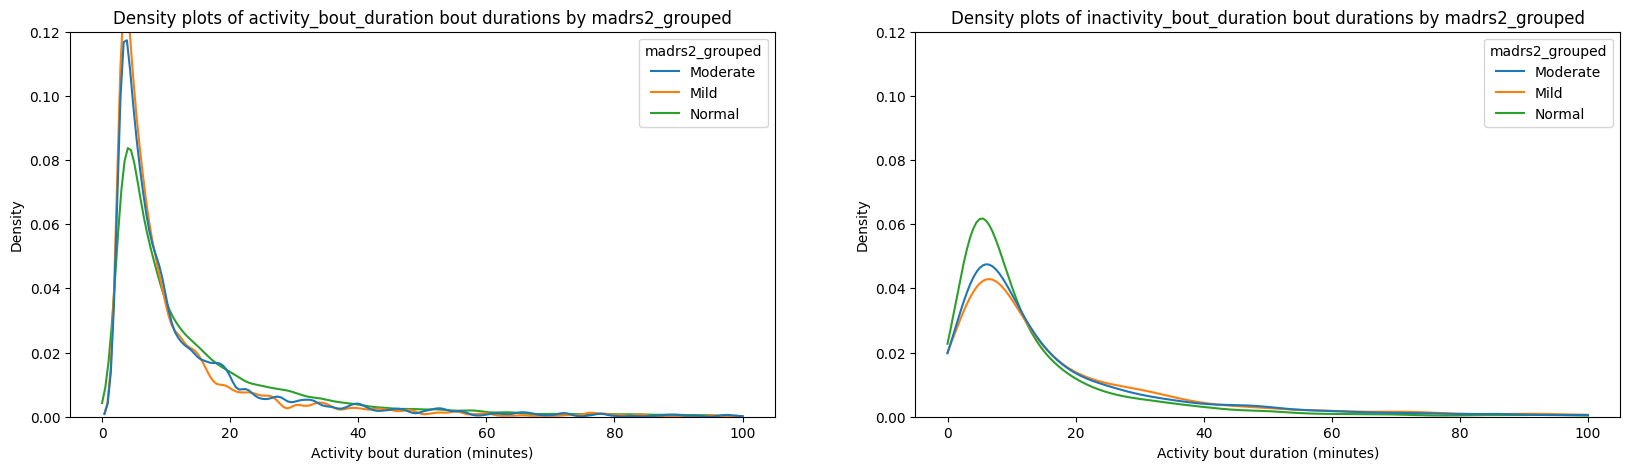

In [44]:
# Plot density of bout durations
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
plot_bout_durations(df_activity_bouts, xcol='activity_bout_duration', ax=ax1)
plot_bout_durations(df_inactivity_bouts, xcol='inactivity_bout_duration', ax=ax2)
ax1.set_ylim(0, 0.12)
ax2.set_ylim(0, 0.12)
fig.show()

From the above it looks like the kurtosis and skew may be different between the normal vs. depressed patients. Depressed patients seem to have shorter active bout durations and longer inactive bout durations

In [45]:
def calculate_bout_features(temp_df,temp_df_activity_bouts, temp_df_inactivity_bouts):
    """
    Group data by number and calculate bout-based features for each number

    Params:
        params: DataFrame containing time-series activity data (not yet split into bouts)
        df_activity_bouts: DataFrame containing activity bouts
        df_inactivity_bouts: DataFrame containing inactivity bouts

    Returns:
        df_bout_features: DataFrame containing bout-based features
    """

    # For each number, calculate the mean duration of activity and inactivity bout durations
    bout_act_dur_mean = temp_df_activity_bouts.groupby('number')['activity_bout_duration'].mean()
    bout_inact_dur_mean = temp_df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].mean()

    # Standard deviation of activity and inactivity bout durations
    bout_act_dur_std = temp_df_activity_bouts.groupby('number')['activity_bout_duration'].std()
    bout_inact_dur_std = temp_df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].std()

    # Coefficient of variation of activity and inactivity bout durations
    bout_act_dur_cv = bout_act_dur_std / bout_act_dur_mean
    bout_inact_dur_cv = bout_inact_dur_std / bout_inact_dur_mean
    
    # Kurtosis of activity and inactivity bouts
    bout_act_dur_kurtosis = temp_df_activity_bouts.groupby('number')['activity_bout_duration'].apply(pd.DataFrame.kurtosis)
    bout_inact_dur_kurtosis = temp_df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(pd.DataFrame.kurtosis)

    # Skewness of activity and inactivity bouts
    bout_act_dur_skew = temp_df_activity_bouts.groupby('number')['activity_bout_duration'].apply(pd.DataFrame.skew)
    bout_inact_dur_skew = temp_df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(pd.DataFrame.skew)

    # Entropy of activity and inactivity bouts
    bout_act_dur_entropy = temp_df_activity_bouts.groupby('number')['activity_bout_duration'].apply(stats.entropy)
    bout_inact_dur_entropy = temp_df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(stats.entropy)

    # Number of bouts of activity and inactivity per day
    bout_act_num = temp_df_activity_bouts.groupby('number')['activity_bout_num'].count() / temp_df.groupby('number')['day_after_first'].max()
    bout_inact_num = temp_df_inactivity_bouts.groupby('number')['inactivity_bout_num'].count() / temp_df.groupby('number')['day_after_first'].max()

    # Create new DataFrame with columns 'number', 'activity_bouts' and 'inactivity_bouts'
    temp_df_bout_features = pd.DataFrame({'number':bout_inact_dur_mean.index,
                                    'bout_inact_num':bout_inact_num.values,
                                    'bout_inact_dur_mean':bout_inact_dur_mean.values,
                                    'bout_inact_dur_std':bout_inact_dur_std.values,
                                    'bout_inact_dur_cv':bout_inact_dur_cv.values,
                                    'bout_inact_dur_kurtosis': bout_inact_dur_kurtosis.values,
                                    'bout_inact_dur_skew': bout_inact_dur_skew.values,
                                    'bout_inact_dur_entropy': bout_inact_dur_entropy.values,
                                    'bout_act_num':bout_act_num.values,
                                    'bout_act_dur_mean':bout_act_dur_mean.values,
                                    'bout_act_dur_std':bout_act_dur_std.values,
                                    'bout_act_dur_cv':bout_act_dur_cv.values,
                                    'bout_act_dur_kurtosis': bout_act_dur_kurtosis.values,
                                    'bout_act_dur_skew': bout_act_dur_skew.values,
                                    'bout_act_dur_entropy': bout_act_dur_entropy.values 
                                    })
    
    # Add MADRS2_grouped column to df_bout_features
    temp_df_bout_features = pd.merge(temp_df_bout_features, temp_df[['number', 'madrs2_grouped']], on=['number'])

    # Remove duplicates
    temp_df_bout_features = temp_df_bout_features.drop_duplicates(subset=['number'])
    
    # Sort by number and reset index
    temp_df_bout_features = temp_df_bout_features.sort_values('number').reset_index(drop=True)

    
    return temp_df_bout_features

df_bout_features = calculate_bout_features(df_feature_input, df_activity_bouts, df_inactivity_bouts)
df_bout_features.head()

# Assert that the number of distinct 'number' in df_bout_features is the same as the number of distinct 'number' in df_feature_input
assert len(df_bout_features['number'].unique()) == len(df_feature_input['number'].unique())

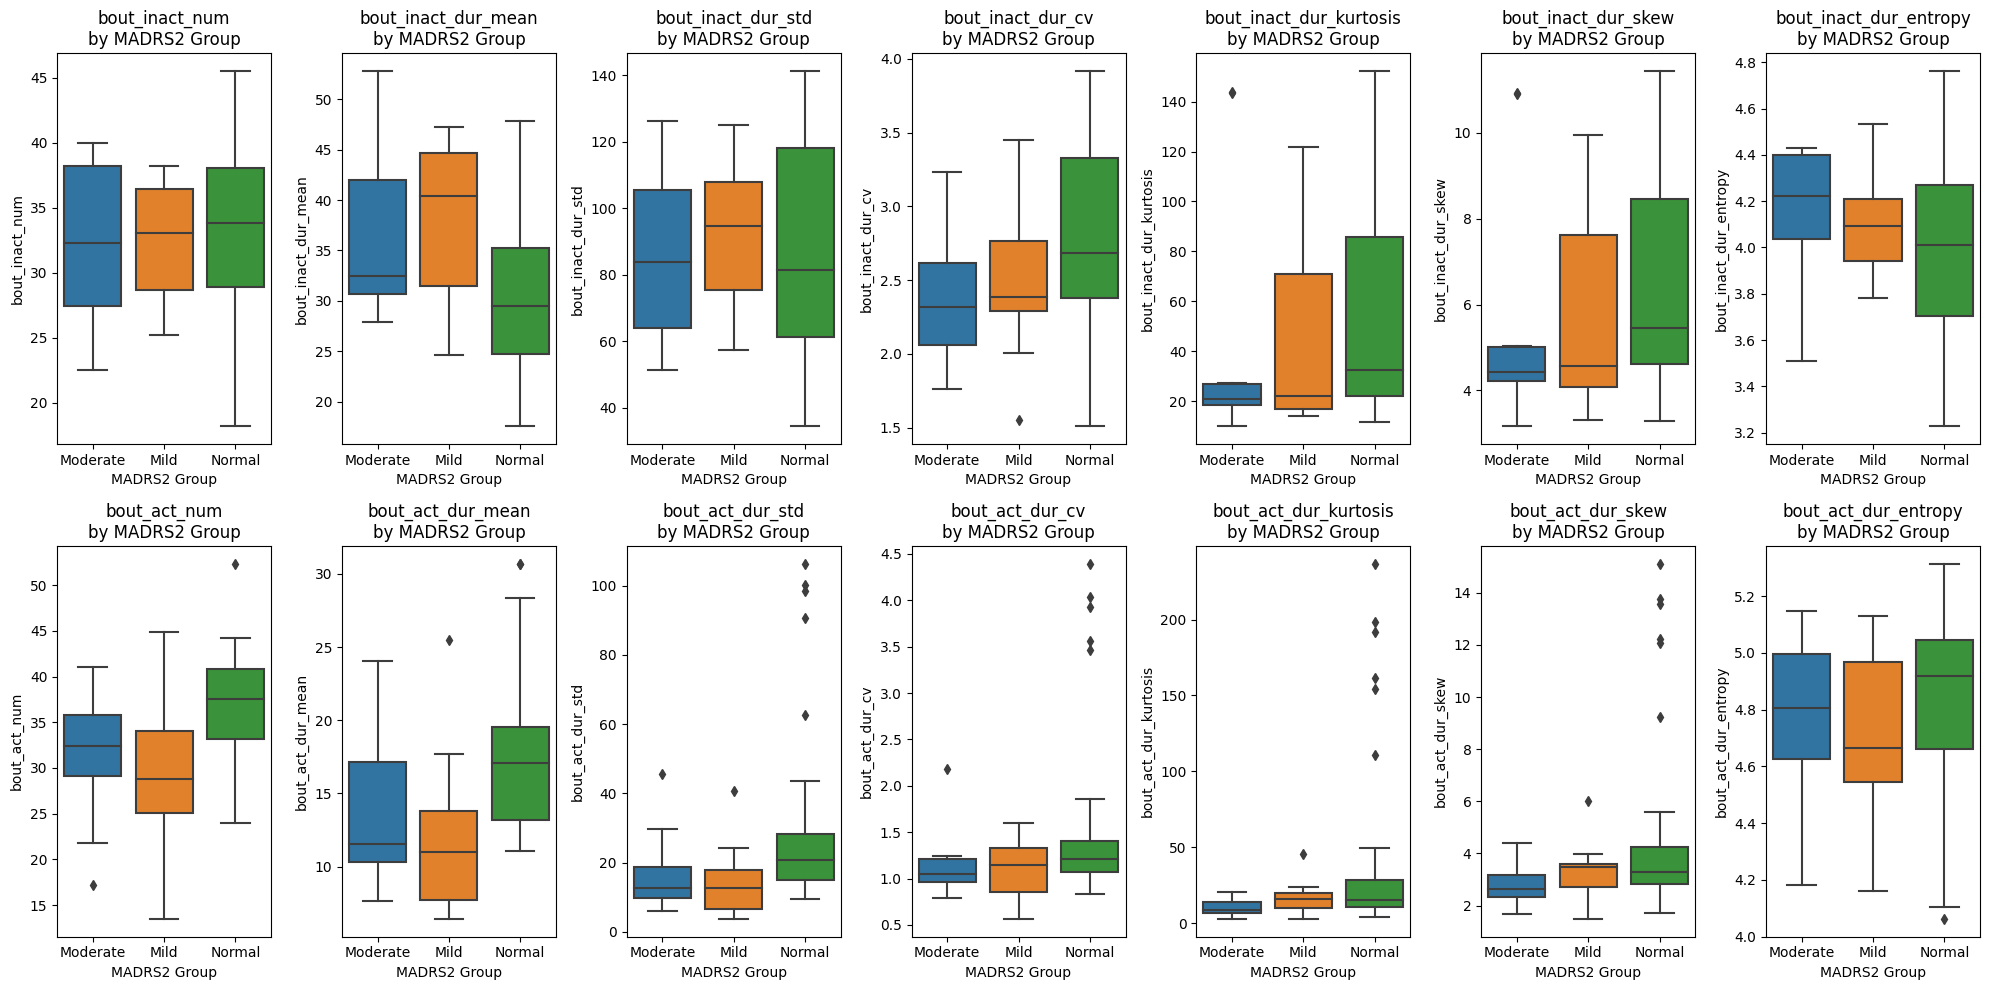

In [46]:
# Boxplot of bout-based features vs. MADRS2_grouped
plot_features(data = df_bout_features, rows=2, cols=7, features=df_bout_features.columns[1:-1])                                                                 

### Merge all the activity-based and bout-based features together into a single dataframe

In [47]:
# Merge df_bout_features with df, dropping 'madrs2_grouped from df_bout_features'
df_features = pd.merge(df_activity_features, df_bout_features.drop('madrs2_grouped', axis=1), on=['number'])

## Step 3: Feature Selection

### Composite decision-tree and greedy feature selection

The following code uses two algorithms to select the most relevant features:
1. Decision tree feature selection returns importance scores of each feature in predicting depression classes
2. Greedy feature selection uses a correlation matrix, identifies features that have the highest correlation with the depression classes, and drops features that are highly correlated with the selected features. It repeats this process

A composite score for each feature is then calculated based on the outcomes of each of these algorithms.

Finally, a new dataframe it outputted that contains the top 30 features based on the composite score.

In [48]:
def feature_selection_decision_tree(df, cols_to_drop=['number', 'madrs2_grouped', 'Normal', 'Mild', 'Moderate'], y_col='madrs2_grouped_ord'):
    """
    Uses a decision tree to calculate feature importances and returns a DataFrame with the feature names and importances.

    Params:
        df: DataFrame with features and MADRS2 Groups (Normal, Mild, Moderate)
        cols_to_drop: List of columns to drop from df
        y_col: Name of column containing MADRS2 Groups (Ordinal)
        
    Returns:
        df_importances: DataFrame with feature names and importances
    """
    # Drop 'number'
    df = df.drop(cols_to_drop, axis=1)
    
    # Set up and fit Decision Tree
    y = df[y_col]
    X = df.drop(columns=y_col)
    tree = DecisionTreeClassifier(class_weight='balanced', random_state=0)
    tree.fit(X, y)

    # Get feature importances and names
    feature_importances = tree.feature_importances_
    feature_names = X.columns

    # Combine importances and names into DataFrame and sort by importance
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances,
    }).sort_values(by='importance', ascending=False)

    # Reset index of df_importances
    df_importances = df_importances.reset_index(drop=True)

    # Drop rows with importance of 0
    df_importances = df_importances[df_importances['importance'] > 0]

    return df_importances

def feature_selection_greedy(df, cols_to_drop=['number', 'madrs2_grouped', 'madrs2_grouped_ord'], corr_drop_threshold=0.8):
    """
    Uses a greedy algorithm to select features that are highly correlated with MADRS2 Group and not highly correlated with each other.

    Params:
        df: DataFrame with features and MADRS2 Groups (Normal, Mild, Moderate)
        cols_to_drop: List of columns to drop from df
        corr_drop_threshold: Threshold for dropping highly correlated features

    Returns:
        selected_features: DataFrame with feature names and MADRS2 Group correlation
    """
    # Drop columns
    df = df.drop(cols_to_drop, axis=1)

    # Initialize a list for selected features and the correlation matrix
    selected_features = {}
    corr = df.corr().abs()

    # Calculate 'MADRS2 Predictive score' by averaging the absolute values of 'Normal', 'Mild' and 'Moderate'
    corr['madrs2_predictive_score'] = (corr['Normal'].abs() + corr['Mild'].abs() + corr['Moderate'].abs())/3

    # Delete 'Normal' 'Mild' 'Moderate' columns
    corr = corr.drop(columns=['Normal', 'Mild', 'Moderate'])

    # Remove 'Normal' 'Mild' 'Moderate' and 'madrs2_predictive_score' rows
    corr = corr.drop(index=['Normal', 'Mild', 'Moderate'])

    # Greedy feature selection
    while not corr.empty:
        # Select feature with highest 'madrs2_predictive_score'
        next_feature = corr['madrs2_predictive_score'].idxmax()
        
        # Add selected feature and its 'madrs2_predictive_score' to the dataframe
        selected_features[next_feature] = corr.loc[next_feature, 'madrs2_predictive_score']

        # Remove selected feature and features highly correlated with it
        correlated_features = corr[next_feature][corr[next_feature] > corr_drop_threshold].index
        corr = corr.drop(columns=[next_feature] + list(correlated_features))
        corr = corr.drop(index=[next_feature] + list(correlated_features))

    # Convert selected_features to a DataFrame, calling the first column 'feature' and the second column 'madrs2_predictive_score'
    selected_features = pd.DataFrame(list(selected_features.items()), columns=['feature', 'madrs2_predictive_score'])
    
    return selected_features

df_greedy_feature = feature_selection_greedy(df_features, corr_drop_threshold=0.9)
df_decision_tree_feature = feature_selection_decision_tree(df_features)


In [49]:
def merge_feature_selection(df_greedy = df_greedy_feature, df_decision_tree = df_decision_tree_feature):
    """
    Merges the greedy and decision tree feature selection results and calculates an average score for each feature.

    Params:
        df_greedy: DataFrame with features and MADRS2 Predictive Scores from greedy feature selection
        df_decision_tree: DataFrame with features and importances from decision tree feature selection
        
    Returns:
        df_feature_selection: DataFrame with features, individual and average scores
    """
    # Merge greedy and decision tree feature selection
    df_feature_selection = pd.merge(df_greedy_feature, df_decision_tree, how='outer', on='feature', suffixes=('_greedy', '_decision_tree'))
    df_feature_selection.columns = ['feature', 'madrs2_predictive_score_greedy', 'importance_decision_tree']

    # Replace nan with 0
    df_feature_selection = df_feature_selection.fillna(0)

    # Normalize the scores using sklearn's minmax scaler
    scaler = MinMaxScaler()
    df_feature_selection[['madrs2_predictive_score_greedy', 'importance_decision_tree']] = scaler.fit_transform(df_feature_selection[['madrs2_predictive_score_greedy', 'importance_decision_tree']])

    # Calculate average score as a new column
    df_feature_selection['average_score'] = (df_feature_selection['madrs2_predictive_score_greedy'] + df_feature_selection['importance_decision_tree']) / 2

    # Sort by average score
    df_feature_selection = df_feature_selection.sort_values(by='average_score', ascending=False)

    # Reindex
    df_feature_selection = df_feature_selection.reset_index(drop=True)

    # Make each column display in 2 decimal places
    df_feature_selection = df_feature_selection.round(2)

    return df_feature_selection

df_feature_scores = merge_feature_selection(df_greedy_feature, df_decision_tree_feature)

In [50]:
# Create new DataFrame with only the top 30 selected features
def create_top_features_df(df, df_feature_scores=df_feature_scores, top_n=len(df_feature_scores)):
    """
    Creates a new DataFrame with only the top n features, number and madrs2 grouping columns

    Params:
        df: DataFrame with features, number and MADRS2 Groups (Normal, Mild, Moderate)
        df_feature_scores: DataFrame with feature names sorted by average score per feature

    Returns:
        df_top_features: DataFrame with top n features, number and MADRS2 Groups (Normal, Mild, Moderate)
    """
    # Create a list of columns to keep
    cols_to_keep = list(['number', 'madrs2_grouped', 'madrs2_grouped_ord', 'Normal', 'Mild', 'Moderate'])

    # Take top n features from df_feature_scores
    top_features = list(df_feature_scores['feature'][:top_n])

    # Sort top_features alphabetically
    top_features.sort()
    
    # Add top features to cols_to_keep
    cols_to_keep.extend(top_features)

    # Create a new DataFrame with only the top features
    df_top_features = df[cols_to_keep].copy()

    return df_top_features

df_selected_features = create_top_features_df(df_features, df_feature_scores=df_feature_scores, top_n=30)

In [51]:
def plot_feature_correlation(data, cols_to_drop=['number', 'madrs2_grouped'], figsize=(30, 30), simple=False, row_start=4, col_end=4, fontsize=12, title='Feature Correlation'):
    """
    Plot a correlation heatmap of features
    
    Params:
        data: dataframe containing features to plot
        cols_to_drop: columns to drop from data before plotting
        figsize: size of heatmap
        simple: flag to indicate whether to plot a simple heatmap or not
        row_start: row to start plotting from
        col_end: column to end plotting at
        fontsize: size of font for annotations
    """
    data = data.drop(cols_to_drop, axis=1)   
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    
    if simple:
        ax = sns.heatmap(data.corr().iloc[row_start:, :col_end],
                    annot=True,
                    cmap='coolwarm_r',
                    fmt='.2f',
                    annot_kws={"fontsize":fontsize},
                    linewidths=3)
    else:
        ax = sns.heatmap(data.corr(),
                    annot=True,
                    cmap='coolwarm_r',
                    fmt='.2f',
                    annot_kws={"fontsize":fontsize},
                    linewidths=3)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

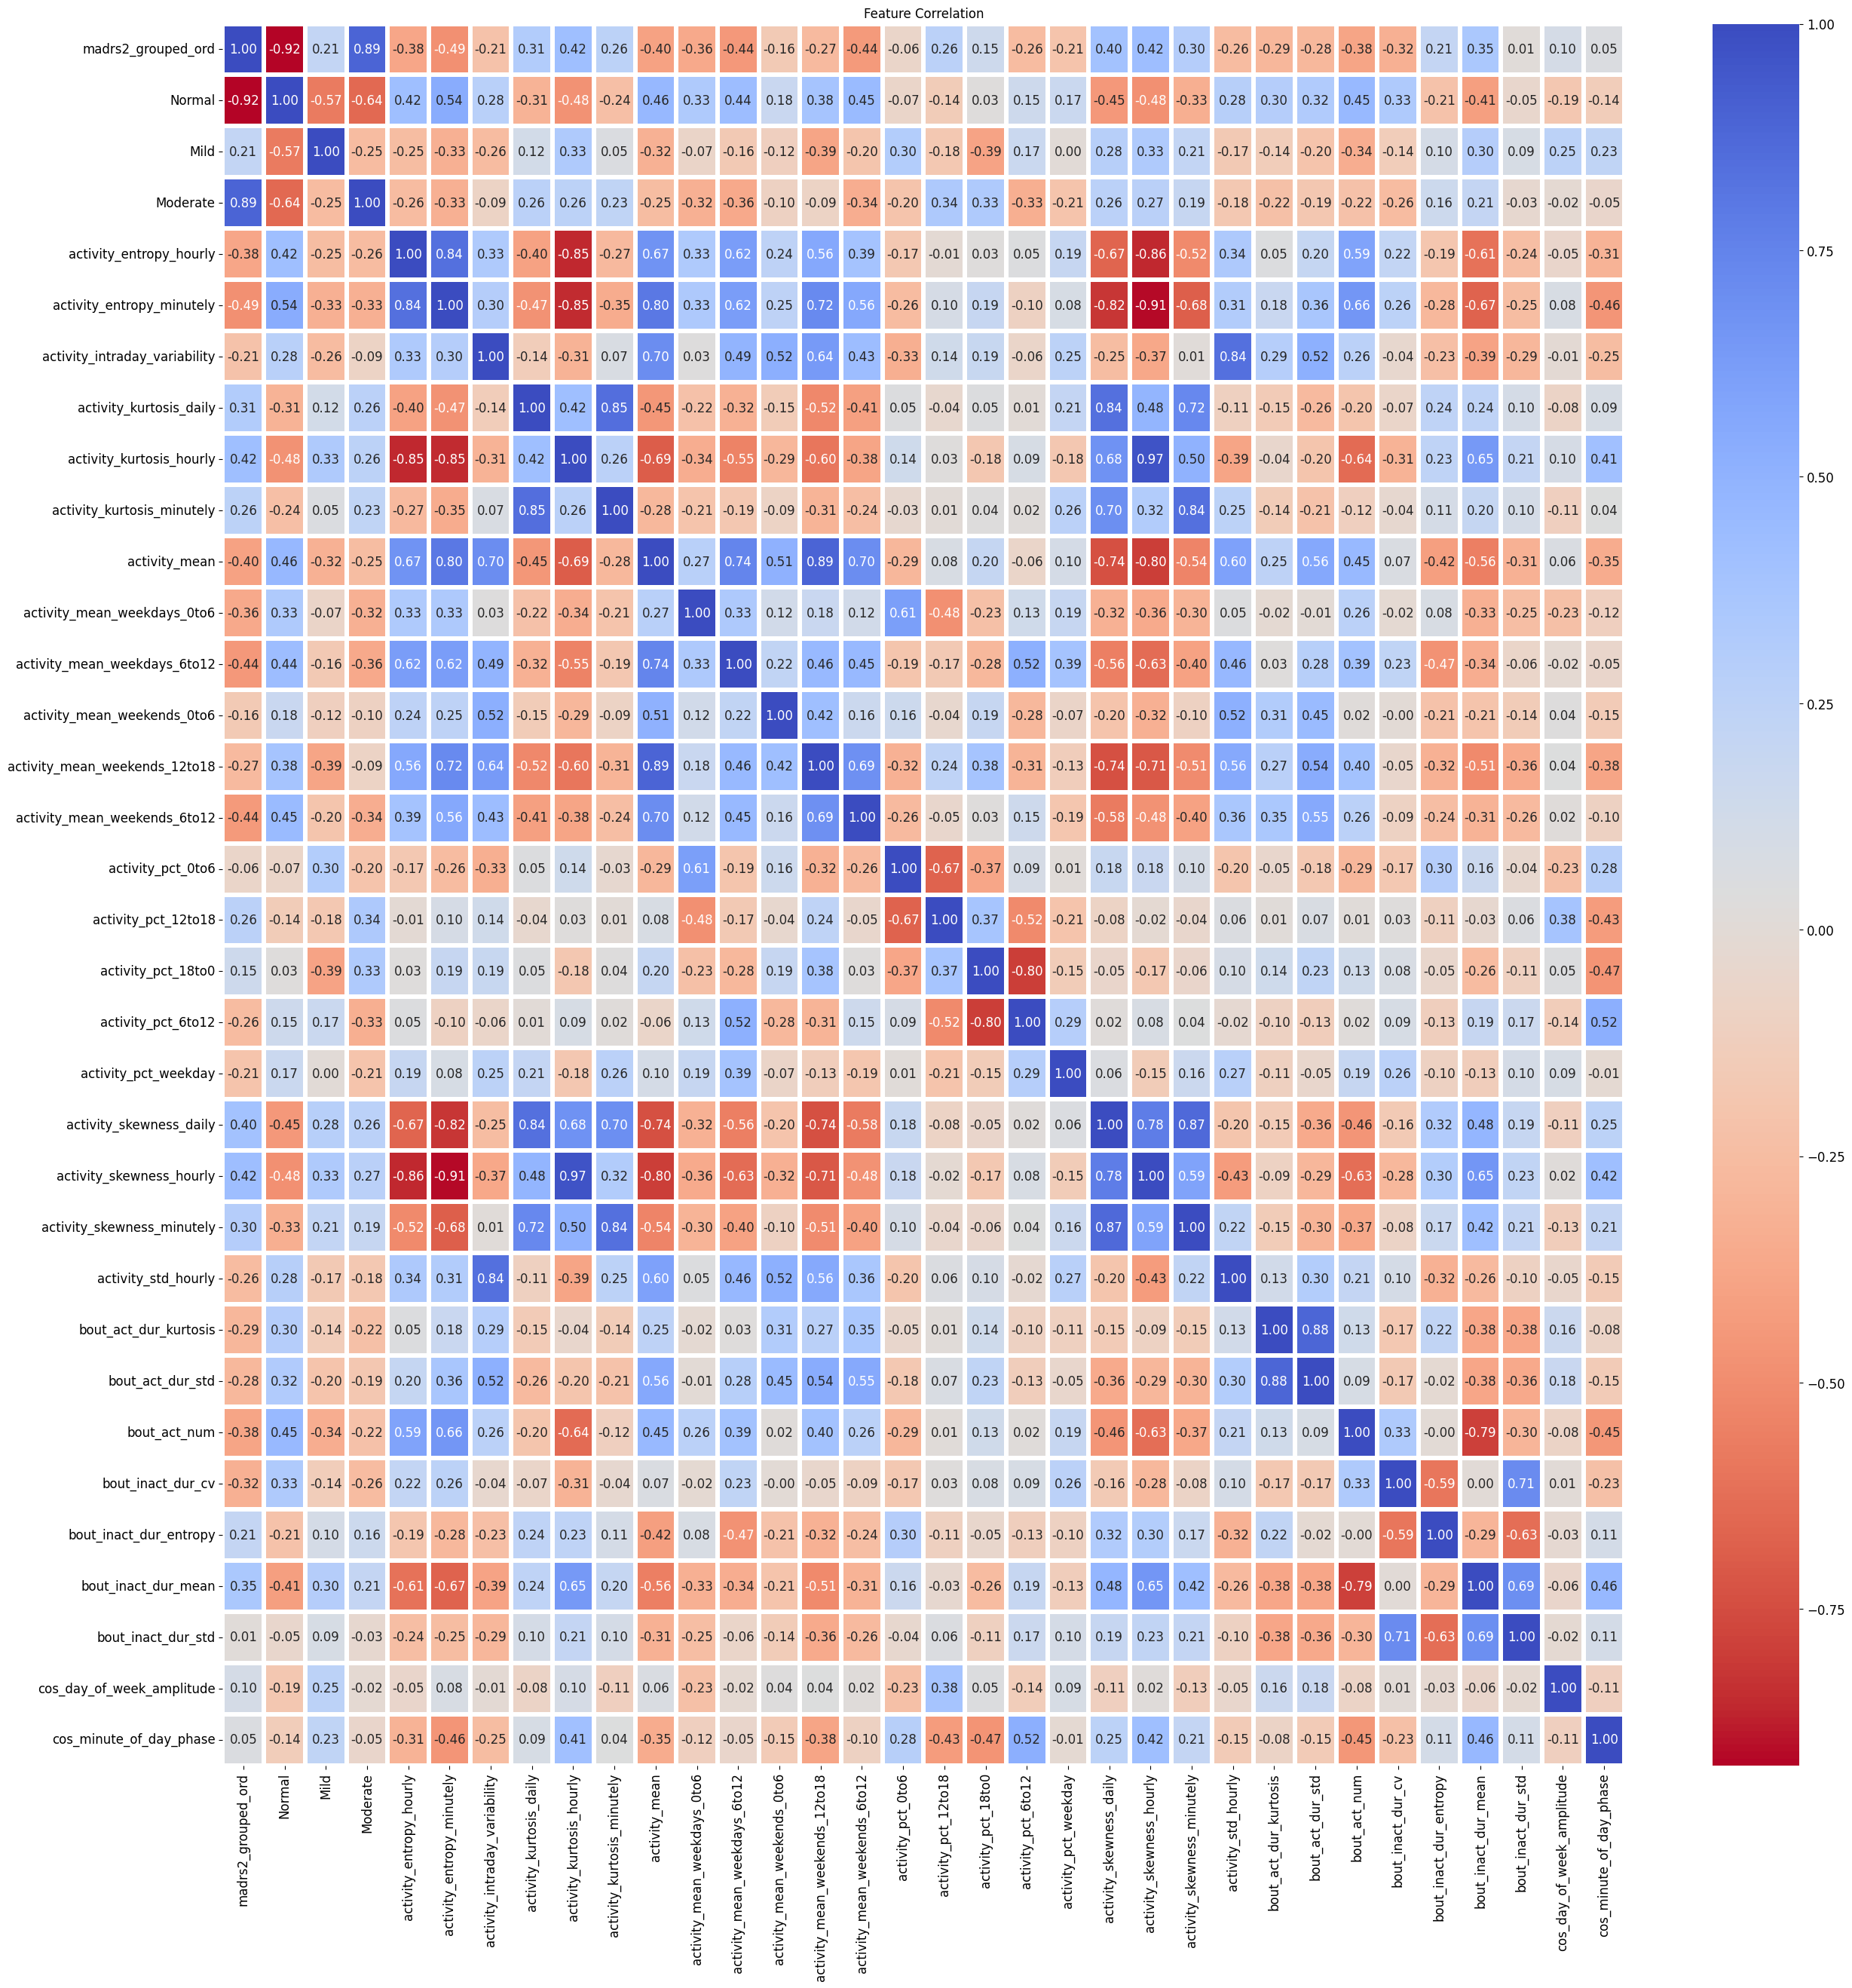

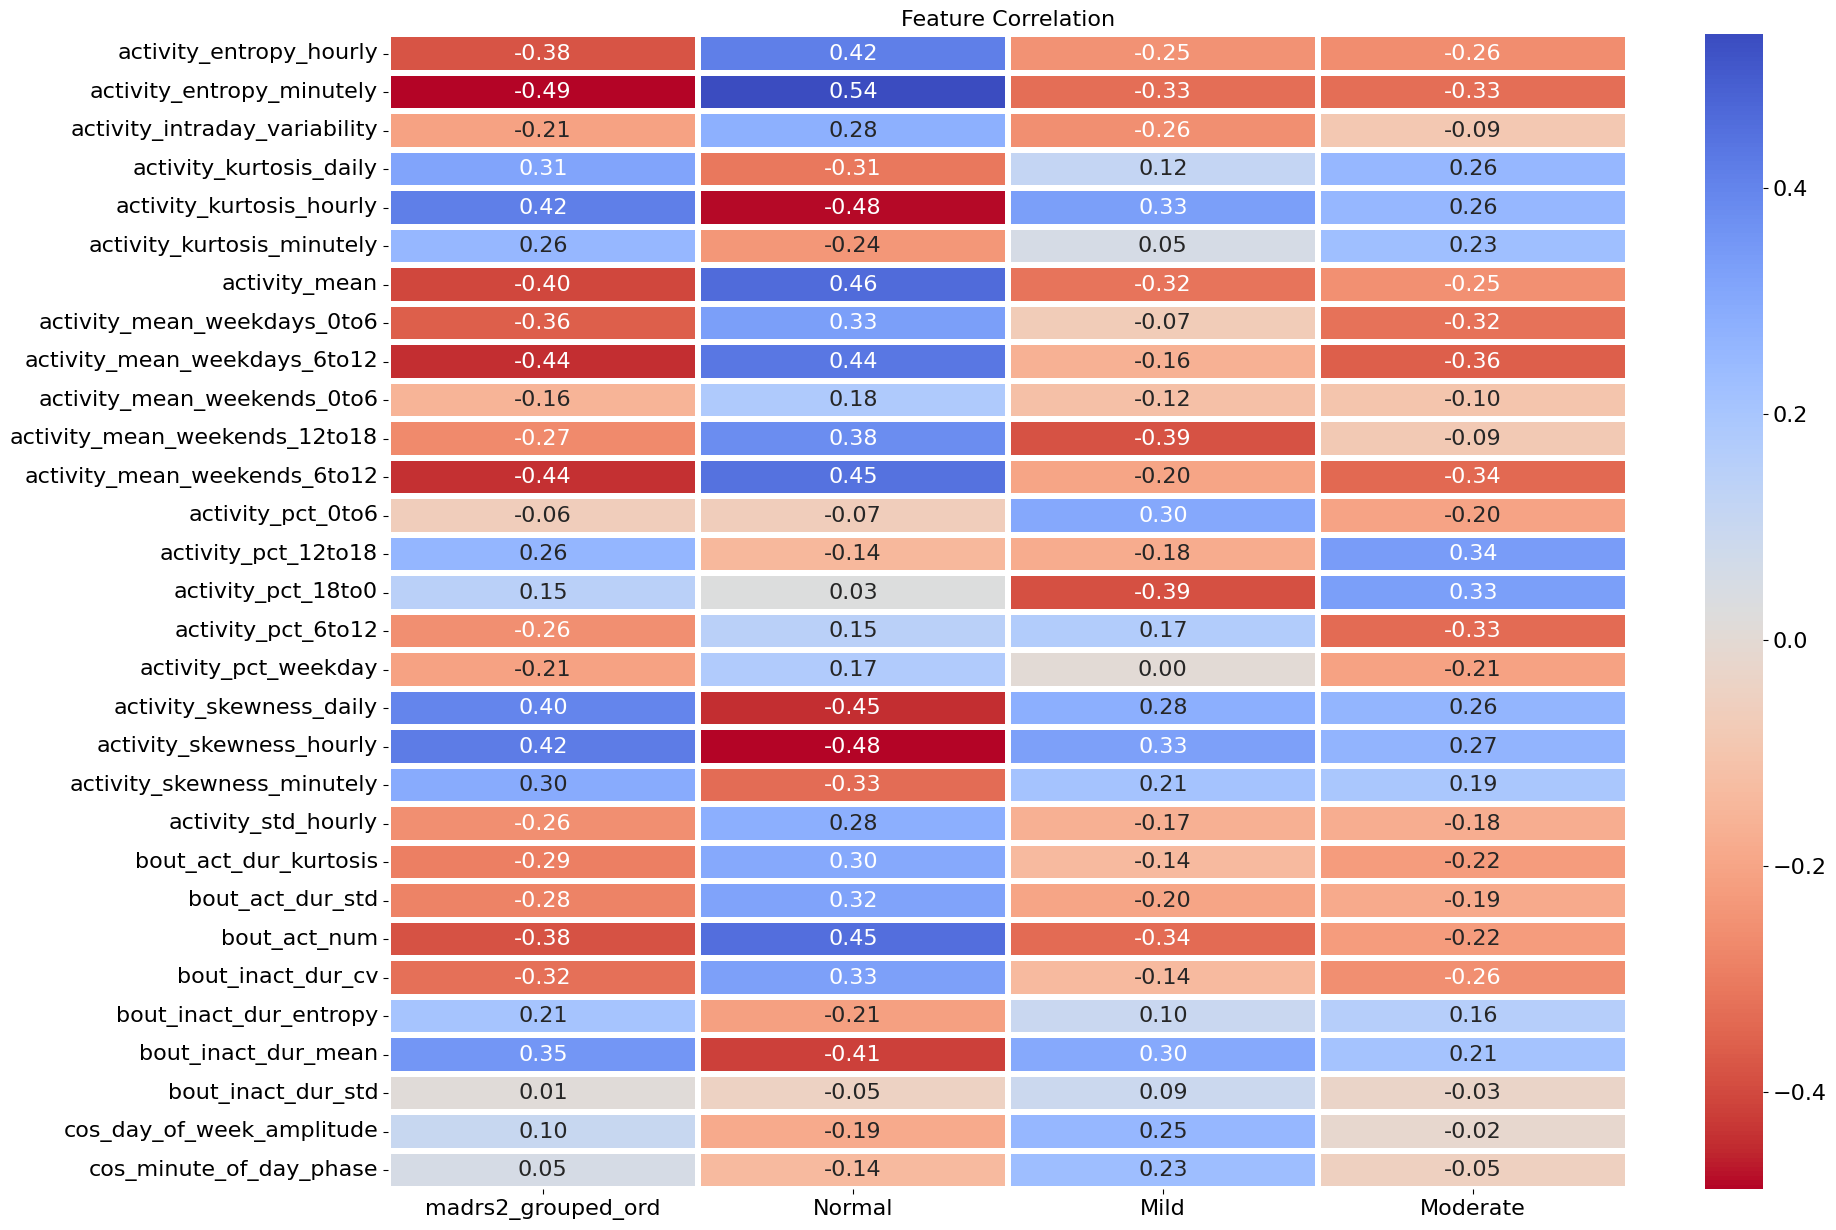

In [52]:
# Plot correlation heatmap of all features. Note that the first four columns are labels.
plot_feature_correlation(data=df_selected_features)
plot_feature_correlation(data=df_selected_features, figsize=(20, 15), fontsize=16, simple=True)

## Step 4: Data Augmentation with Cross-Data Subject Fusion

We used cross-subject data fusion as a method to enhance our machine learning model. We randomly combined time segments from similar user groups to create new timeseries data. This approach was used to boost the diversity and size of the limited training dataset. By randomly bringing together information from various individuals, the synthesized data hopefully introduces a wider range of scenarios and user behaviors, improving our model's ability to adapt and make accurate predictions. The fusion process should help the model recognize common patterns shared among users, making it more robust in handling new, unseen situations during testing. Additionally, this technique acts as a safeguard against overfitting, ensuring the model learns more generalized representations, ultimately leading to a more effective and reliable machine learning solution.

### Functions

In [53]:
def add_basic_columns(temp_df,weeks,user_type,subj_num):
    """Append activity with necessary values into synthesized data frame"""
    
    if 'index' in temp_df:
        temp_df = temp_df.drop('index', axis=1) 

    #add columns    
    temp_df['number']=''
    temp_df['madrs2_grouped']=user_type
    temp_df['madrs2_grouped_ord']=0

    #append values based on user_type
    if user_type=='Mild':
        temp_df['Mild']=True
        temp_df['madrs2_grouped_ord']=1 #mild
        temp_df['number']=append_unique_names('mild',len(temp_df),weeks,subj_num)
    else:
        temp_df['Mild']=False

    if user_type=='Moderate':
        temp_df['Moderate']=True
        temp_df['madrs2_grouped_ord']=2 #moderate
        temp_df['number']=append_unique_names('mod',len(temp_df),weeks,subj_num)
    else:
        temp_df['Moderate']=False

    if user_type=='Normal':
        temp_df['Normal']=True
        temp_df['madrs2_grouped_ord']=0 #normal
        temp_df['number']=append_unique_names('norm',len(temp_df),weeks,subj_num)
    else:
        temp_df['Normal']=False
        
    return temp_df

In [54]:
def add_timestamps(synth_data_length, year=2003, month=5, day=12):
    """
    Adds timestamp and timestamp breakdown which is required for other calculations.
    
    Specify the year, month, and day you want to start from. (2003-05-12 is a monday, or day_of_week=0)

    Params:
        synth_data_length: int, number of minutes of synthetic data to generate
        year: int, year to start from
        month: int, month to start from
        day: int, day to start from

    Returns:
        timestamps: pd.Series, timestamps for each minute of synthetic data
    """
    days_total=synth_data_length/1440

    # Create a range of timestamps starting from midnight
    start_timestamp = pd.Timestamp(year, month, day, 0, 0, 0)
    end_timestamp = start_timestamp + pd.DateOffset(days=days_total)  # Add 1 day to cover 24 hours
    timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='1min')
    timestamps = timestamps[:-1]
    
    return timestamps

In [55]:
def append_unique_names(suffx,array_length,weeks,subj_num):  
    """
    Appends unique user ids to synth data
    
    Params:
        suffx: string to append to user id
        array_length: length of array to append user ids to
        weeks: number of weeks to simulate
        subj_num: number to start user id count at

    Returns:
        array of user ids
    """
    user_type='condition_1'+suffx
    user_count=0+subj_num
    user_names=[]
    for i in range(array_length):
        if ((i%(weeks*7*1440)==0) & (i!=0)):         
            user_count+=1
            user_names.append(user_type+str(user_count))
        else:
            user_names.append(user_type+str(user_count)) 

    return np.array(user_names) 

In [56]:
def get_real_metrics_for_comparison(temp_df_activity, temp_df_bout, user_type):
    """
    Gets max value, min value, std, and means from real data to compare to generated data

    Params:
        temp_df_activity: dataframe of activity data
        temp_df_bout: dataframe of bout data
        user_type: user type to get metrics for

    Returns:
        activity_means: mean of activity data
        activity_stds: std of activity data
        activity_maxs: max of activity data
        activity_mins: min of activity data
        bout_means: mean of bout data
        bout_stds: std of bout data
        bout_maxs: max of bout data
        bout_mins: min of bout data
    """

    #Get bout means from real data
    activity_means=temp_df_activity.select_dtypes(include=np.number)\
        .groupby(temp_df_activity['madrs2_grouped'])\
        .mean().loc[user_type]

    activity_stds=temp_df_activity.select_dtypes(include=np.number)\
        .groupby(temp_df_activity['madrs2_grouped'])\
        .std().loc[user_type]

    activity_maxs=temp_df_activity.select_dtypes(include=np.number)\
        .groupby(temp_df_activity['madrs2_grouped'])\
        .max().loc[user_type]

    activity_mins=temp_df_activity.select_dtypes(include=np.number)\
        .groupby(temp_df_activity['madrs2_grouped'])\
        .min().loc[user_type]

    if len(temp_df_bout)!=0:
        #Get bout means from real data
        bout_means=temp_df_bout.select_dtypes(include=np.number)\
            .groupby(temp_df_bout['madrs2_grouped'])\
            .mean().loc[user_type]

        bout_stds=temp_df_bout.select_dtypes(include=np.number)\
            .groupby(temp_df_bout['madrs2_grouped'])\
            .std().loc[user_type]

        bout_maxs=temp_df_bout.select_dtypes(include=np.number)\
            .groupby(temp_df_bout['madrs2_grouped'])\
            .max().loc[user_type]

        bout_mins=temp_df_bout.select_dtypes(include=np.number)\
            .groupby(temp_df_bout['madrs2_grouped'])\
            .min().loc[user_type]

        act_metrics=[activity_means,activity_stds,activity_maxs,activity_mins]
        bout_metrics=[bout_means,bout_stds,bout_maxs,bout_mins]
    
        return activity_means,activity_stds,activity_maxs,activity_mins,bout_means,bout_stds,bout_maxs,bout_mins
    else:
        return activity_means,activity_stds,activity_maxs,activity_mins

In [63]:
def verify_new_user(accuracy, synth_df_bout_features,synth_df_activity_features,\
                    df_activity_features,df_bout_features,user_type,top_25_features):
    """
    This function will compare the newly generated user to the real users. It will return a list of generated users to delete if they do not meet the conditions.
    
    Params:
        accuracy: float, the accuracy to use for the comparison
        synth_df_bout_features: dataframe, the bout features of the newly generated user
        synth_df_activity_features: dataframe, the activity features of the newly generated user
        df_activity_features: dataframe, the activity features of the real users
        df_bout_features: dataframe, the bout features of the real users
        user_type: string, the type of user to compare to
        top_features: list, the top features to compare to

    Returns:
        user_names_to_delete: list, the list of users to delete
    """

    user_names_to_delete=[]

    # Return real metrics
    activity_means,activity_stds,activity_maxs,activity_mins,bout_means,bout_stds,bout_maxs,bout_mins=\
        get_real_metrics_for_comparison(df_activity_features, df_bout_features, user_type)
    
    # Checks bout metrics
    for column_name,std_value, mean_value,min_value,max_value in zip(bout_stds.index,bout_stds, bout_means,bout_mins,bout_maxs):
        
        if column_name in top_25_features:           
            #create a list of users to remove if they do not meet conditions
            for index, row in synth_df_bout_features.iterrows():
                if ((row[column_name]<(mean_value-std_value*accuracy)) |\
                    (row[column_name]>(mean_value+std_value*accuracy)) |\
                    (row[column_name]<min_value) | (row[column_name]>max_value)):
                        user_names_to_delete.append(row.number)
                        
    
    #Checks activity metrics
    for column_name,std_value, mean_value,min_value,max_value in zip(activity_stds.index,activity_stds, activity_means,activity_mins,activity_maxs):
        if column_name in top_25_features:
            for index, row in synth_df_activity_features.iterrows():
                if ((row[column_name]<(mean_value-std_value*accuracy)) |\
                    (row[column_name]>(mean_value+std_value*accuracy)) |\
                    (row[column_name]<min_value) | (row[column_name]>max_value)):
                        user_names_to_delete.append(row.number)
   
    return user_names_to_delete

In [64]:
def add_noise_to_timeseries(synthesized_data, noise_std=0.04):
    """
    This function adds Gaussian noise to a synthesized time series. The noise is generated

    Params:
        synthesized_data: the synthesized time series data
        noise_std: the standard deviation of the Gaussian noise to be added to the time series

    Returns:
        noisy_data: the synthesized time series with added noise
    """

    # Generate Gaussian noise with the same shape as the synthesized time series
    noise = 1-(np.random.normal(loc=0.0, scale=noise_std, size=synthesized_data.shape))

    # Add noise to the synthesized data
    noisy_data = synthesized_data * noise

    # Clip any negative values to 0 to ensure non-negativity
    noisy_data = np.maximum(noisy_data, 0)

    return noisy_data

In [65]:
def create_df_for_category(df, category):
    """Returns depression data based on type set user"""
    return df.loc[df.madrs2_grouped==category]

def select_random_user(temp_df_day):
    """Selects a random user with the specified type for each time segment pulled"""
    random_user = np.random.choice(temp_df_day['number'].unique())
    return temp_df_day.loc[temp_df_day['number'] == random_user]

def select_random_day(temp_user_df, day):
    """Selects a random day from the random user that matches the day of week of interest"""
    picked_day = np.random.choice(temp_user_df.loc[temp_user_df['day_of_week'] == day, 'date'].unique())
    return temp_user_df.loc[temp_user_df['date'] == picked_day]

In [66]:
def synthesize_data(df,synth_data, user_type, weeks=1, hours=24,num_users=1):
    """Assembles newly generated data by pulling time segments from real data subject"""
    # ignore the specific warning:
    warnings.filterwarnings("ignore")
    
    #creates a temporary df to hold user types of interest from the real data
    df_group = create_df_for_category(df, user_type)

    #number of weeks to craft
    for _ in range(weeks):
        
        day=0

        #loops until desired user data is generated
        while synth_data.shape[0]<(num_users*10080*weeks): 
            temp_day_synth=pd.DataFrame({})
            if day==7: #reset the day to 0 after one week cycle
                day=0
    
            temp_df_day = df_group.loc[df['day_of_week'] == day]#gets data from day of week
            
            #creates one day's worth of data
            for hour in range(0,hours,4):
                
                #ensure that it picks a day from real data that has a full 1440 minutes of readings
                length_of_day = 0
                while length_of_day != 1440:
                    temp_user_df = select_random_user(temp_df_day)
                    temp_user_df = select_random_day(temp_user_df, day)
                    length_of_day = len(temp_user_df)
                    
                #pull desired time segment to append to new data
                temp_user_df = temp_user_df.loc[(temp_user_df['hour'] == hour)|\
                                                (temp_user_df['hour'] == hour+1)|(temp_user_df['hour'] == hour+2)|\
                                                (temp_user_df['hour'] == hour+3)]
                
                #add the time segment to new data
                temp_user_df = temp_user_df[['activity']].reset_index()                
                temp_day_synth = pd.concat([temp_day_synth, temp_user_df])
            
            #add full days worth of data to final synth dataframe
            synth_data = pd.concat([synth_data,temp_day_synth])
            
            day+=1 #iterrate to the next day of week

    return synth_data

In [67]:
def generate_samples(noise, df_splits, df_activity_features,df_bout_features,\
                     accuracy, num_users,user_type,top25_features,subj_num,remove_out):
    """Generates new users until number of desired new subjects are created that fall within acceptable metric range"""

    print(f'starting {user_type}...')
    
    if remove_out==True:
        num_users=num_users*2
    #set up an empty dataframe to hold new synthesized users
    synth_data = pd.DataFrame()

    samples_completed=0 #keeps track of samples created

    weeks=1
    while synth_data.shape[0]<(num_users*10080*weeks):
        synth_data = synthesize_data(df_splits, synth_data,user_type=user_type,weeks=weeks, hours=24,num_users=num_users)

        #appends unique user_id (number) to dataframe
        synth_data=add_basic_columns(synth_data,weeks,user_type,subj_num)

        #adds artificial timestamp and timestamp breakdown
        synth_data['timestamp']=add_timestamps(len(synth_data))
        synth_data=calculate_time_features(synth_data)

        #calculates activity features
        synth_df_activity_features = calculate_activity_features(synth_data)

        #analysizes_bouts
        synth_df_activity_bouts, synth_df_inactivity_bouts = make_bout_dfs(synth_data)

        #calculates bout features
        synth_df_bout_features = calculate_bout_features(synth_data,synth_df_activity_bouts, synth_df_inactivity_bouts)

        ##Verify newly generated data
        #If a generated subjects data metrics fall outside 2 standard deviations of real data then remove
        users_to_remove=verify_new_user(accuracy, synth_df_bout_features,synth_df_activity_features,\
                                        df_activity_features,df_bout_features,user_type,top25_features)

        synth_data=synth_data.loc[~synth_data['number'].isin(users_to_remove)]

        #prepares synth data to be fed back into the generator if number of subjects desired is not met
        if samples_completed<(int(synth_data.shape[0]/(weeks*10080))):
            samples_completed=int(synth_data.shape[0]/(weeks*10080))
            print(f'{samples_completed/2} samples completed out of {num_users/2}')
        if len(users_to_remove)!=0:
            synth_data=synth_data[['activity']]
            
    # Get column names of both real and synth DataFrames and add missing empty columns to real df 
    columns_df_splits = set(df_splits.columns)
    columns_synth_data = set(synth_data.columns)
    columns_not_in_synth_data = list(columns_df_splits.difference(columns_synth_data))

    for column in columns_not_in_synth_data:
        synth_data[column]=None
        
    #add noise to activity    
    synth_data.activity=add_noise_to_timeseries(synth_data.activity, noise_std=noise)
    
    #trim subject that fall out of activity range
    if remove_out==True:
        synth_df_activity_features = calculate_activity_features(synth_data)
        for feature in ['activity_entropy_hourly','activity_interday_stability','activiy_skewness_hourly']:
            r=[]
            if feature=='activiy_skewness_hourly': final=True
            else: final=False
            r=remove_outliers(synth_df_activity_features, df_activity_features,user_type,num_users,feature,final)
            synth_data=synth_data.loc[~synth_data['number'].isin(r)]

    print('completed')
    
    return synth_data


In [68]:
def remove_outliers(synth_df_activity_features, df_activity_features,user_type,num_users,feature,final):
    """Removes outliers from synthetic data based on real data"""

    if num_users>=10:
        num_users = math.floor(num_users/2/2)
        if (final==True): num_users=num_users
        user_names_to_delete=[]
        #return real metrics
        activity_means,activity_stds,activity_maxs,activity_mins=\
            get_real_metrics_for_comparison(df_activity_features,pd.DataFrame({}), user_type)

        #Checks activity metrics
        for column_name,std_value, mean_value,min_value,max_value in zip(activity_stds.index,activity_stds, activity_means,activity_mins,activity_maxs):
            if column_name in [feature]:
                pos_neg=mean_value-synth_df_activity_features[column_name].mean()
                if pos_neg<0:
                    synth_df_activity_features=synth_df_activity_features.sort_values([column_name],ascending=False)
                else: 
                    synth_df_activity_features=synth_df_activity_features.sort_values([column_name],ascending=True)

                user_names_to_delete=synth_df_activity_features[0:num_users].number.unique()
        return user_names_to_delete

In [69]:
#gets a list of the features of interest
top25_features=df_selected_features.drop(['number','madrs2_grouped','madrs2_grouped_ord',\
                                          'Normal','Mild','Moderate'],axis=1).columns

### Run Data Augmentation Code

In [70]:
#Sets a new dataframe -- DO NOT RUN this unless you want to erase already generated data or this is the first run
df_generated=pd.DataFrame({})

In [71]:
#Run this code to generate new data. Each subject generated will have one week of data
#This will NOT delete the samples you have already created. If you want to create a new dataframe run above cell
#WARNING: this can take awhile depending on amount of subjects you are generating.

#----------------------------------------------------
noise=0.02 #amount of noise you want to add to segments
accuracy=3 #how many standard deviations can the newly generated data be away from the feature means
depression_dic={'Moderate':28,'Mild':30,'Normal':8} #set how many samples you want for each category. The current numbers are set so that there is 40 n per class, to get rid of class imbalance
remove_out=False #this will remove outliers if mean is off but will slow down generation process
#----------------------------------------------------

def get_id_number(x):
    """Get next id number if df_generated already exists"""
    pattern = r'\d+$'
    match = re.search(pattern, x['number'])
    return int(match.group()) if match else None

next_subj_num=0
if len(df_generated) != 0:
    if len(df_generated.loc[df_generated.madrs2_grouped==depression_type]!=0):
        next_subj_num=(df_generated.loc[df_generated.madrs2_grouped==depression_type]\
                        .apply(get_id_number, axis=1)).max() +1

#Generate Data
for index,value in depression_dic.items():
    depression_type=index
    num_subjects=value
    if value!=0:
        df_generated=pd.concat([df_generated,generate_samples(noise,df_splits,df_activity_features,\
                                                              df_bout_features,accuracy, num_subjects,\
                                                              depression_type,top25_features,next_subj_num,remove_out)])
df_generated.reset_index().drop('index',axis=1,inplace=True)

starting Moderate...
1.0 samples completed out of 14.0
2.5 samples completed out of 14.0
4.5 samples completed out of 14.0
6.0 samples completed out of 14.0
8.0 samples completed out of 14.0
9.5 samples completed out of 14.0
10.5 samples completed out of 14.0
11.5 samples completed out of 14.0
12.0 samples completed out of 14.0
12.5 samples completed out of 14.0
13.0 samples completed out of 14.0
13.5 samples completed out of 14.0
14.0 samples completed out of 14.0
completed
starting Mild...
3.0 samples completed out of 15.0
7.0 samples completed out of 15.0
9.0 samples completed out of 15.0
10.5 samples completed out of 15.0
13.0 samples completed out of 15.0
13.5 samples completed out of 15.0
14.0 samples completed out of 15.0
14.5 samples completed out of 15.0
15.0 samples completed out of 15.0
completed
starting Normal...
2.5 samples completed out of 4.0
4.0 samples completed out of 4.0
completed


In [74]:
# Sort
df_generated = df_generated.sort_values(by=['number', 'timestamp'])

In [75]:
# Calculates activity features
gen_df_activity_features = calculate_activity_features(df_generated)

# Analysizes bouts
gen_df_activity_bouts, gen_df_inactivity_bouts = make_bout_dfs(df_generated)

# Calculates bout features
gen_df_bout_features = calculate_bout_features(df_generated,gen_df_activity_bouts, gen_df_inactivity_bouts)

### Analysis of Generated Data and Real Data

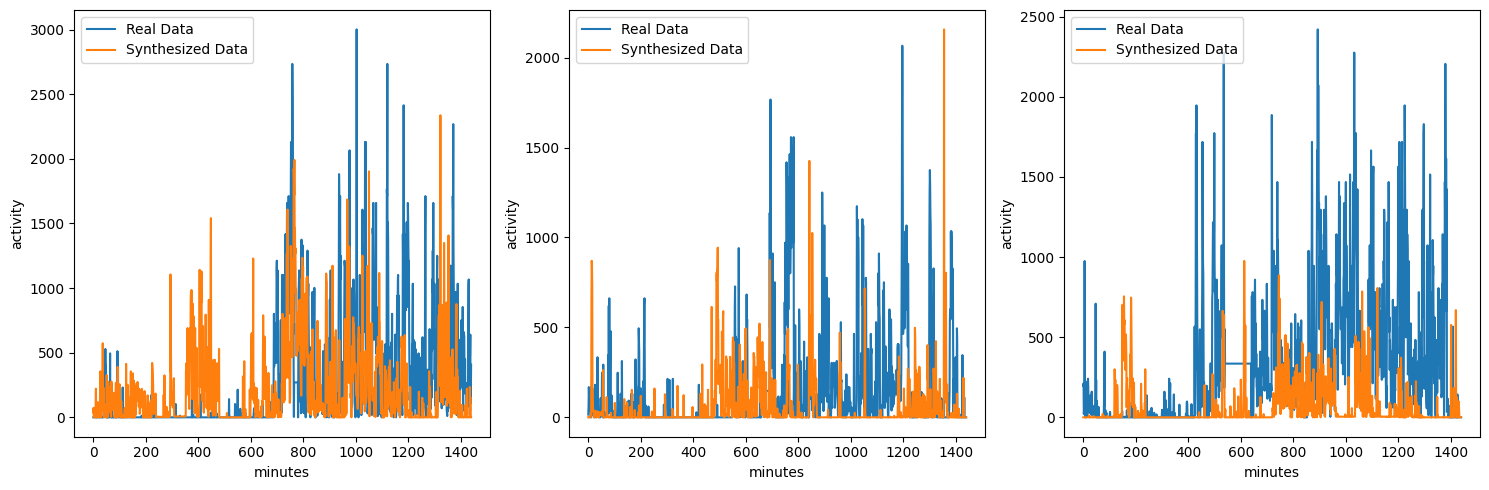

In [77]:
# Do a sample visual analysis of generated data
max_sample=10
random_samples = np.random.choice(np.arange(0, max_sample + 1), size=3, replace=False)

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loops through the random samples and plots data on each subplot
for i, sample in enumerate(random_samples):
    synth_sample = df_generated[1440 * sample : 1440 * sample + 1440].activity.values
    real_sample = df_splits[1440 * sample : 1440 * sample + 1440].activity.values
    sns.lineplot(data=real_sample, ax=axes[i], label="Real Data")
    sns.lineplot(data=synth_sample, ax=axes[i], label="Synthesized Data")

    # Set labels for x-axis and y-axis
    axes[i].set_xlabel('minutes')
    axes[i].set_ylabel('activity')
    axes[i].legend()
 
plt.tight_layout()
plt.show()

In [78]:
def compare_generated_activity_data(depression_type,df_activity_features,gen_df_activity_features):
    """
    Compares generated activity data to real data. Change depression_type to compare to different depression types.

    In the plots, "Synth" is the generated data. All other columns are real data.

    Params:
        depression_type: string, type of depression to compare to (Normal, Mild, Moderate)
        df_activity_features: dataframe, real activity data
        gen_df_activity_features: dataframe, generated activity data
    """
    print(f"Comparing generated activity data with original data for {depression_type} depression")
    gen_df_activity_features['madrs2_grouped'][gen_df_activity_features['madrs2_grouped']==depression_type]='Synth'
    temp_df_activity=pd.concat([gen_df_activity_features,df_activity_features])
    plot_activity_features(temp_df_activity)
    gen_df_activity_features['madrs2_grouped'][gen_df_activity_features['madrs2_grouped']=='Synth']=depression_type

def compare_generated_cos_data(depression_type,df_activity_features,gen_df_activity_features):
    """
    Compare generated cosine parameter data with original data

    In the plots, "Synth" is the generated data. All other columns are real data.

    Params:
        depression_type: type of depression
        
    """
    print(f"Comparing generated cosine parameter data with original data for {depression_type} depression")
    gen_df_activity_features['madrs2_grouped'][gen_df_activity_features['madrs2_grouped']==depression_type]='Synth'
    temp_df_activity=pd.concat([gen_df_activity_features,df_activity_features])
    plot_cos_activity_features(temp_df_activity)
    gen_df_activity_features['madrs2_grouped'][gen_df_activity_features['madrs2_grouped']=='Synth']=depression_type

def compare_generated_bout_data(depression_type,df_bout_features,gen_df_bout_features):
    """
    Compares the generated activity and inactivity bout data with the original data

    In the plots, "Synth" is the generated data. All other columns are real data.

    Params:
        depression_type: string, type of depression
        df_bout_features: dataframe, original bout data
        gen_df_bout_features: dataframe, generated bout data
    """
    print(f"Comparing generated bout data with original data for {depression_type} depression")
    gen_df_bout_features['madrs2_grouped'][gen_df_bout_features['madrs2_grouped']==depression_type]='Synth'
    temp_df=pd.concat([gen_df_bout_features,df_bout_features])
    plot_features(data = temp_df, rows=3, cols=5, features=df_bout_features.columns[1:-1])
    gen_df_bout_features['madrs2_grouped'][gen_df_bout_features['madrs2_grouped']=='Synth']=depression_type

Comparing generated activity data with original data for Moderate depression


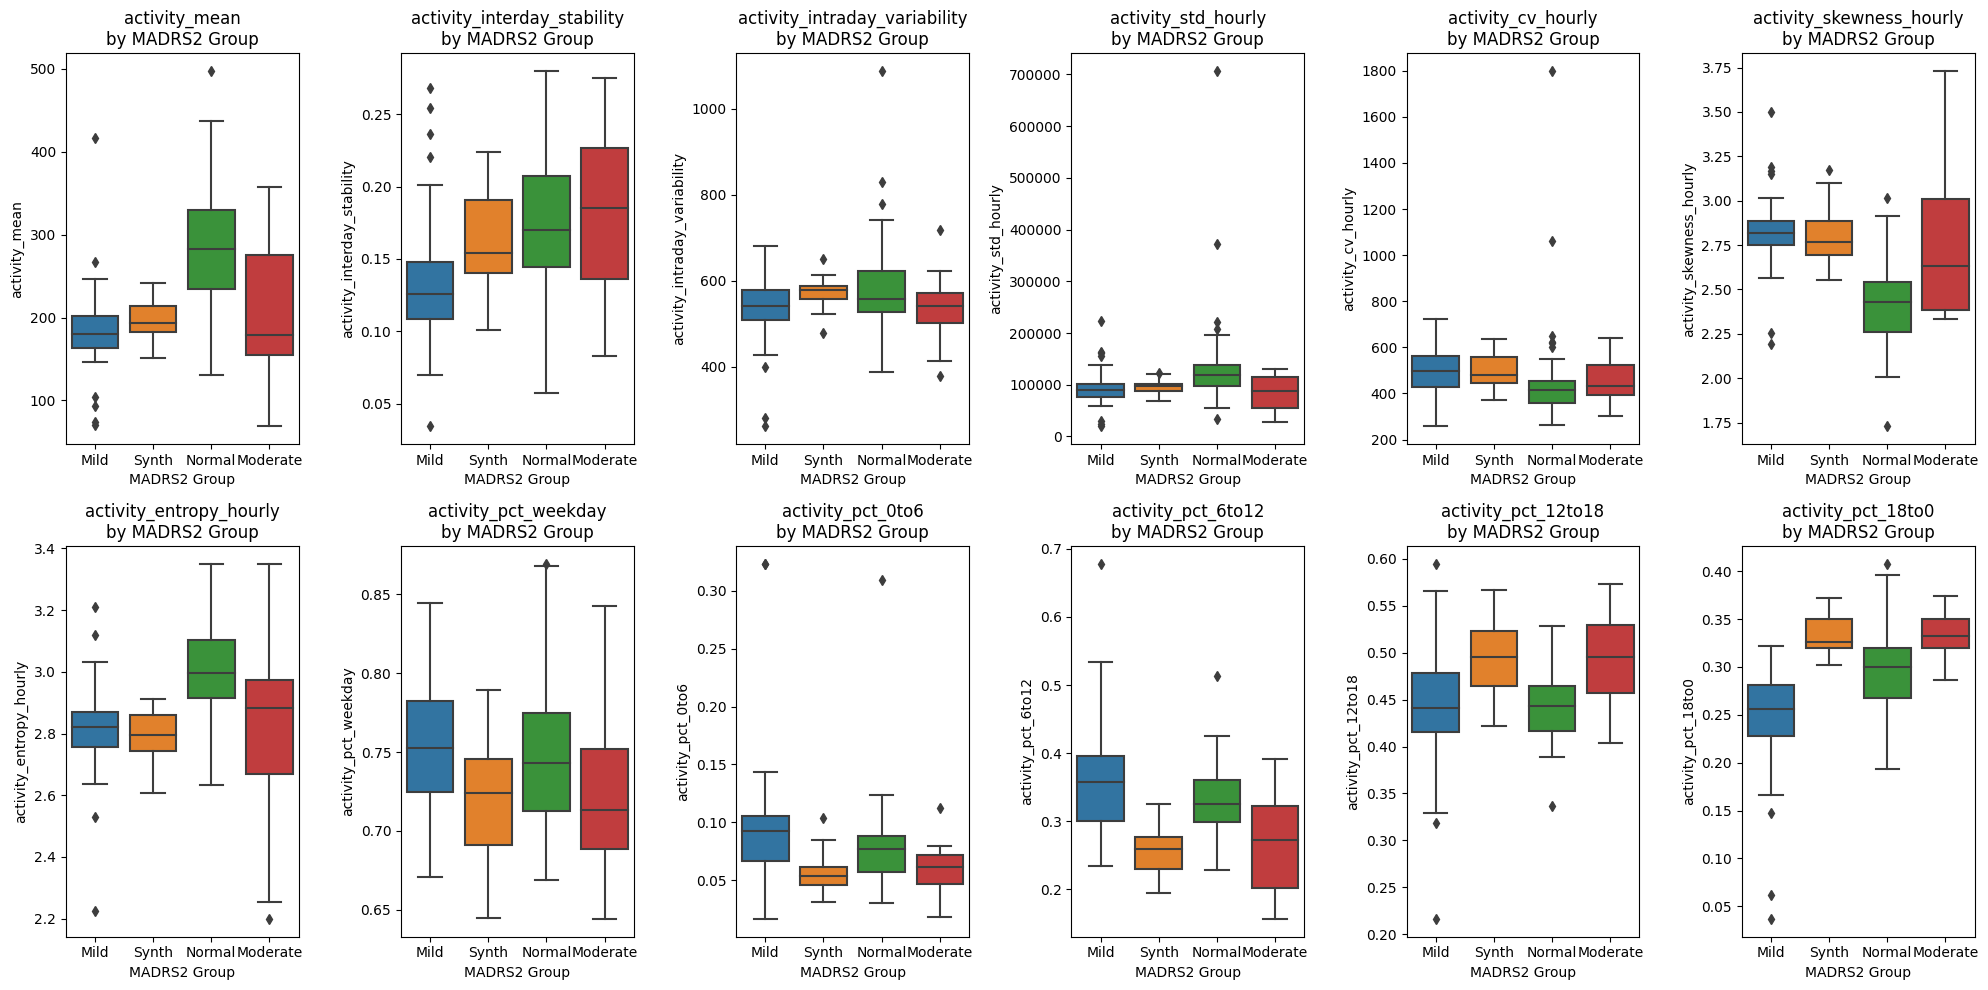

In [80]:
depression_type = 'Moderate'
compare_generated_activity_data(depression_type,df_activity_features,gen_df_activity_features)

Comparing generated cosine parameter data with original data for Moderate depression


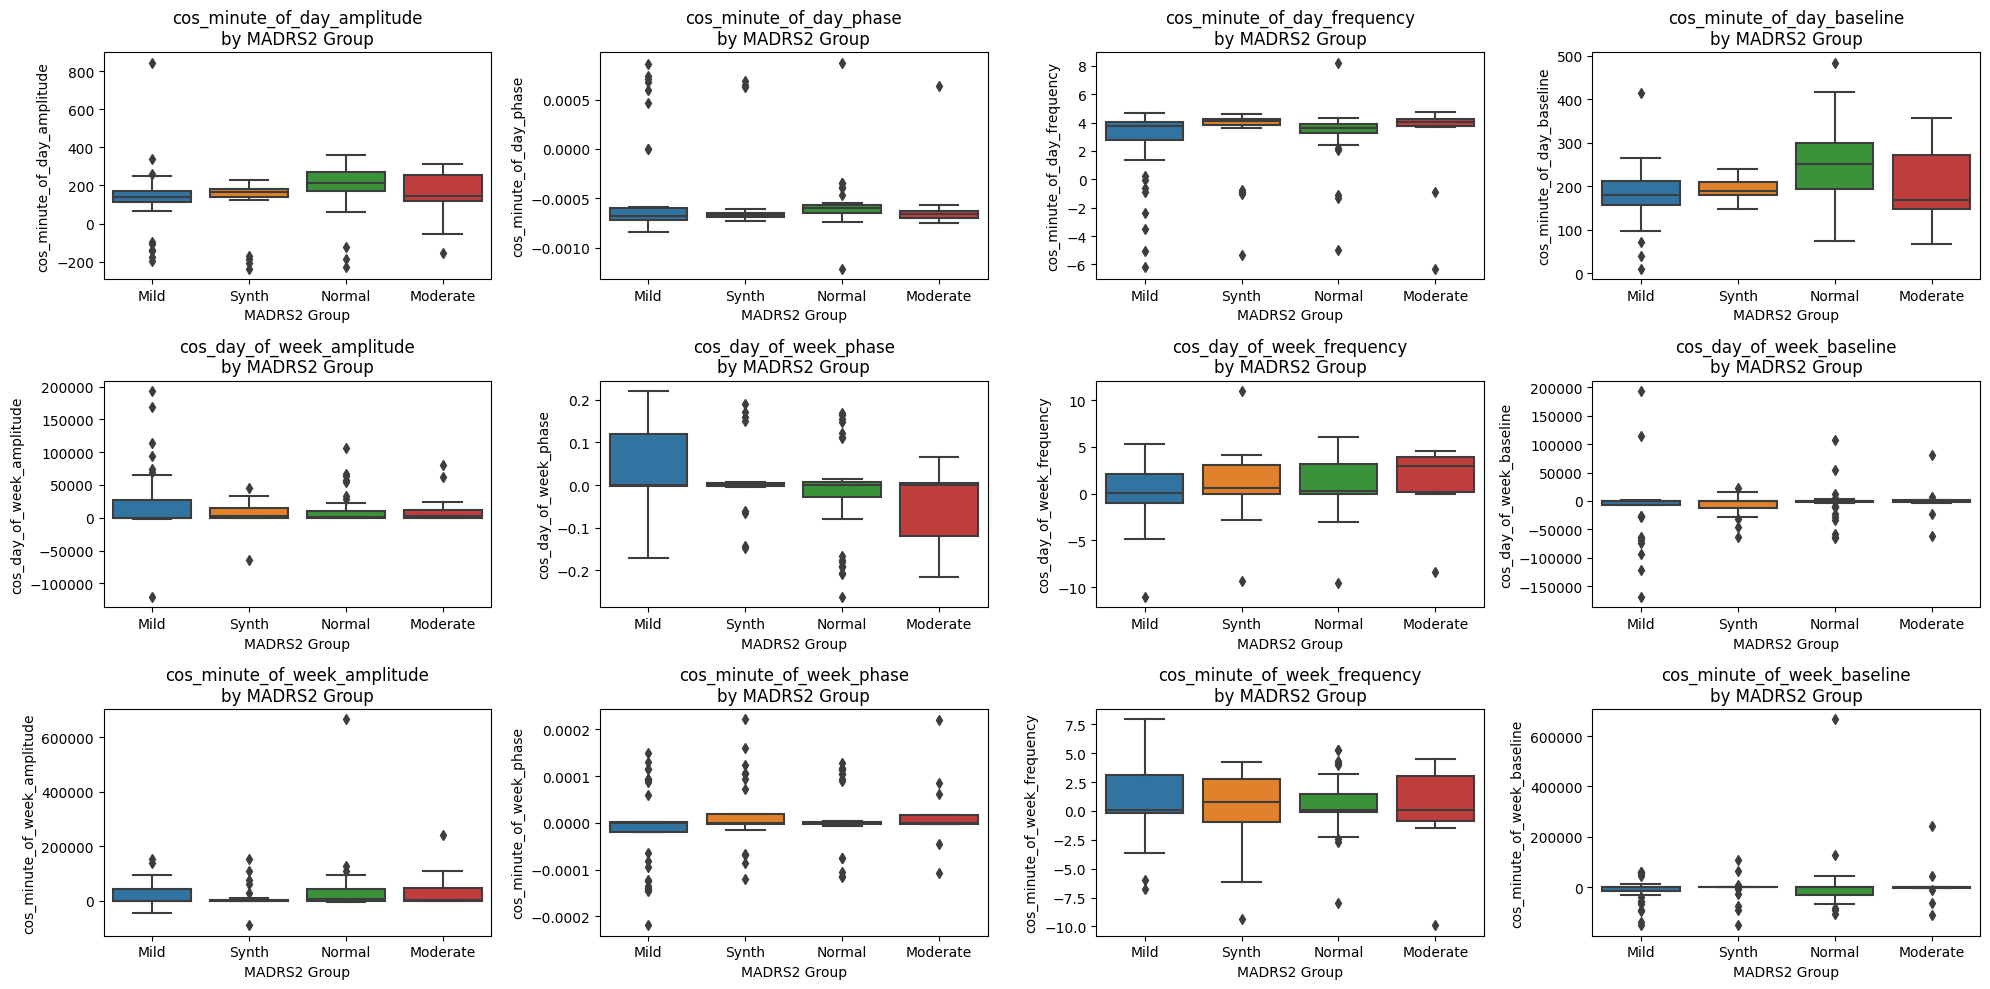

In [81]:
compare_generated_cos_data(depression_type,df_activity_features,gen_df_activity_features)

Comparing generated bout data with original data for Moderate depression


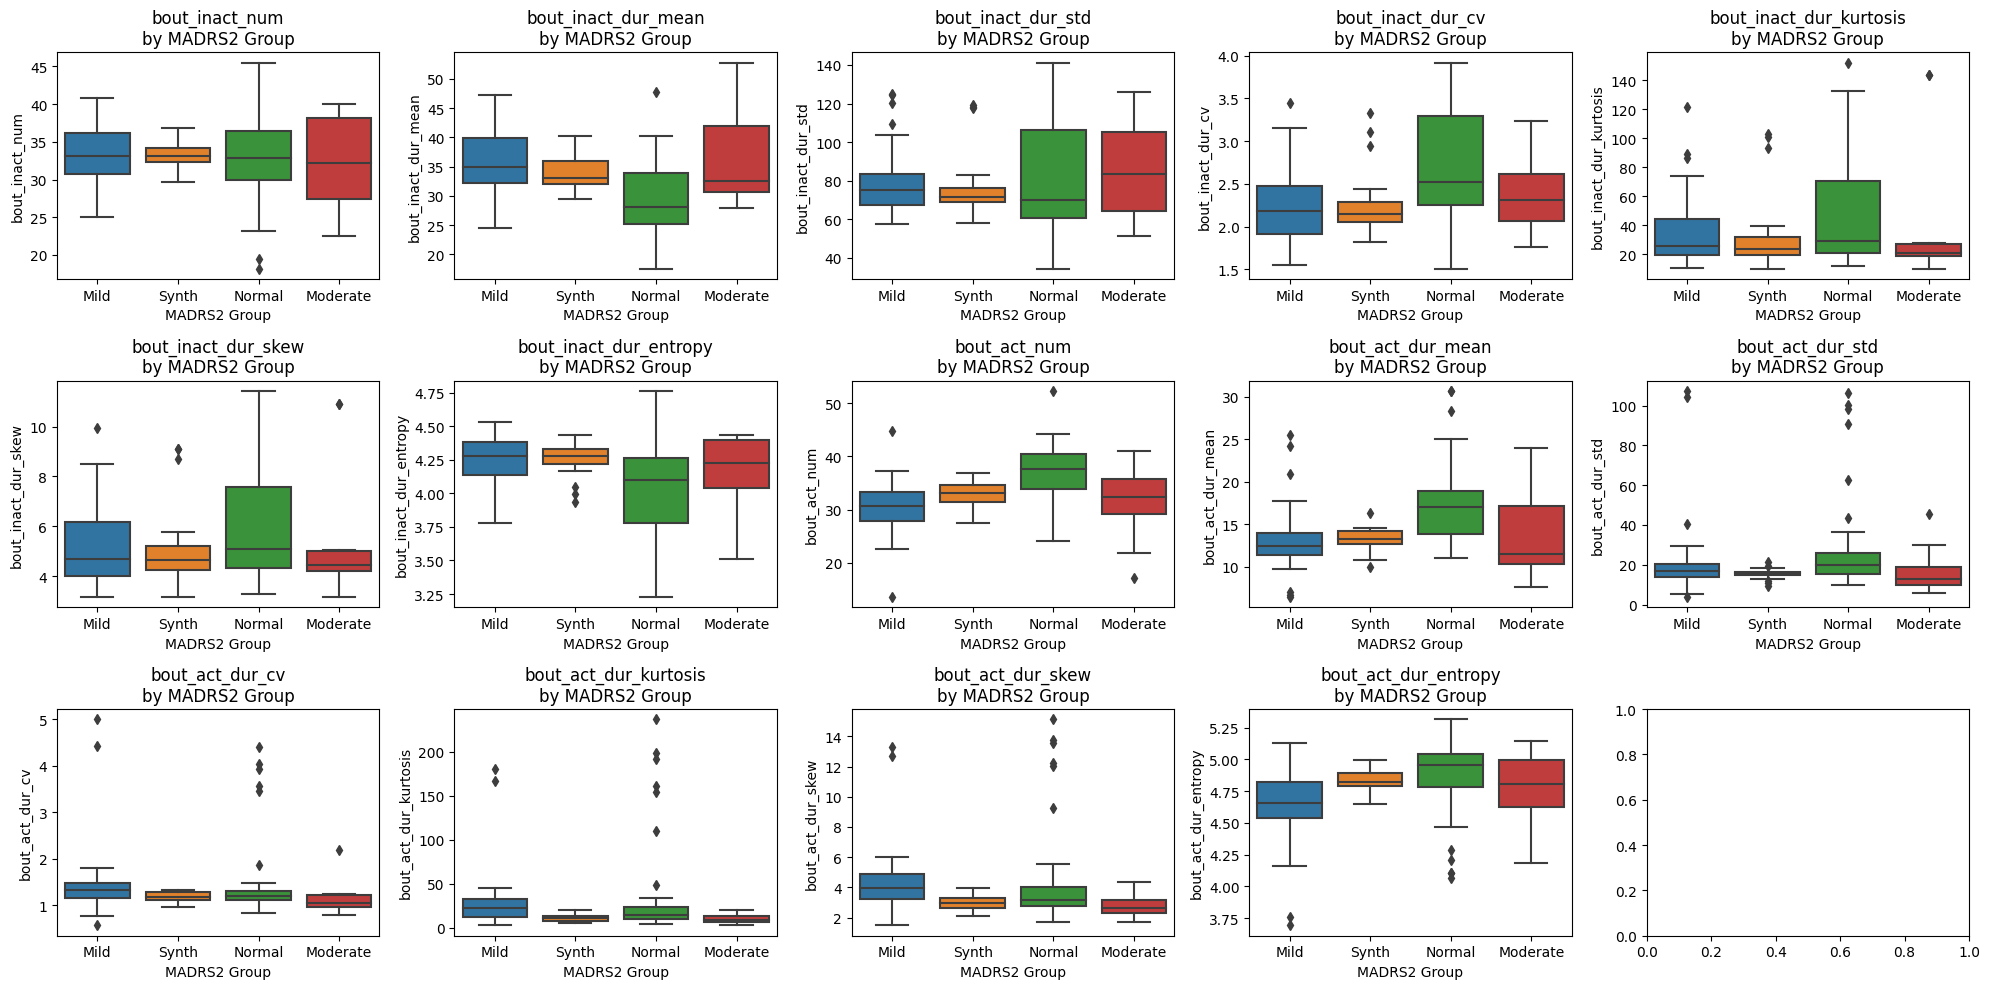

In [82]:
compare_generated_bout_data(depression_type,df_bout_features,gen_df_bout_features)  

As seen in the charts above, the synthetic data's features for Moderate depression are similar to actual Moderate depression patients. This analysis was also done for Mild patients and Normal patients separately

### Export generated data with real data

In [83]:
# Export generated and real data together
pd.concat([df_splits,df_generated]).to_csv('../data/processed/data_augmented.csv', index=False)

In [84]:
# Export df_selected_features as a csv to serve as an input to the next notebook
gen_df_features = pd.merge(gen_df_activity_features, gen_df_bout_features.drop('madrs2_grouped', axis=1), on=['number'])
gen_df_selected_features = create_top_features_df(gen_df_features, df_feature_scores=df_feature_scores, top_n=30)
pd.concat([df_selected_features,gen_df_selected_features]).to_csv('../data/processed/selected_features_augmented.csv', index=False)

In [85]:
print(pd.concat([df_generated,df_splits]).madrs2_grouped.value_counts()/10080)

madrs2_grouped
Mild        40.0
Moderate    40.0
Normal      40.0
Name: count, dtype: float64
